In [3]:
import os
import io
os.chdir("/home/medo/miniconda/UniBSV/")

In [4]:
# download of the unibsv git
if not os.path.exists("unibsv"):
  !git clone https://gitlab.com/data-challenge-gd4h/unibsv.git
!pip install pdfminer.six
!pip install pymupdf

# Test d'extraction

## Aperçu du pdf

In [5]:
pdf_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N20_09082022.pdf"
#pdf_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N11_31052022.pdf"
#pdf_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N14_21062022.pdf"
#pdf_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N20_09082022.pdf"
#pdf_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N01_22032022.pdf"
pdf_name = os.path.split(pdf_path)[-1][:-4]

## Extraction des sections avec la taille et la couleur des titres - methode dict

In [6]:
import fitz 

doc = fitz.open(pdf_path)
page = doc.load_page(1)

def clamp_zone_to_page(page, zone_coords):

    page_width, page_height = page.rect[2], page.rect[3]

    clamped_coords = [
        max(0, min(zone_coords[0], page_width - 1)),
        max(0, min(zone_coords[1], page_height - 1)),
        min(zone_coords[2], page_width),
        min(zone_coords[3], page_height),
    ]

    return clamped_coords

def get_block_numbers_in_zone(page, bbox):
    bbox = clamp_zone_to_page(page, bbox)
    print(bbox)
    block_numbers = []
    extracted_text = page.get_text("dict", sort=True, flags=fitz.TEXTFLAGS_TEXT)

    for block in extracted_text["blocks"]:
        if block["type"] == 0:
            block_bbox = block["bbox"]

            if block_bbox[0] >= bbox[0] and block_bbox[1] >= bbox[1] and block_bbox[2] <= bbox[2] and block_bbox[3] <= bbox[3]:
                block_numbers.append(block["number"])

    return block_numbers

In [7]:
def calculate_intersection_area(bbox1, bbox2):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    if x1 < x2 and y1 < y2:
        return (x2 - x1) * (y2 - y1)
    return 0


def get_block_numbers_in_zone(page, bbox, threshold=0.8):
    block_numbers = []
    extracted_text = page.get_text("dict", sort=True, flags=fitz.TEXTFLAGS_TEXT)

    for block in extracted_text["blocks"]:
        if block["type"] == 0:
            block_bbox = block["bbox"]
            intersection_area = calculate_intersection_area(block_bbox, bbox)

            block_area = (block_bbox[2] - block_bbox[0]) * (block_bbox[3] - block_bbox[1])
            overlap_ratio = intersection_area / block_area

            if overlap_ratio >= threshold:
                block_numbers.append(block["number"])

    return block_numbers
get_block_numbers_in_zone(page,(0, 500, 0, 150))

[]

## Extraction du text par zone

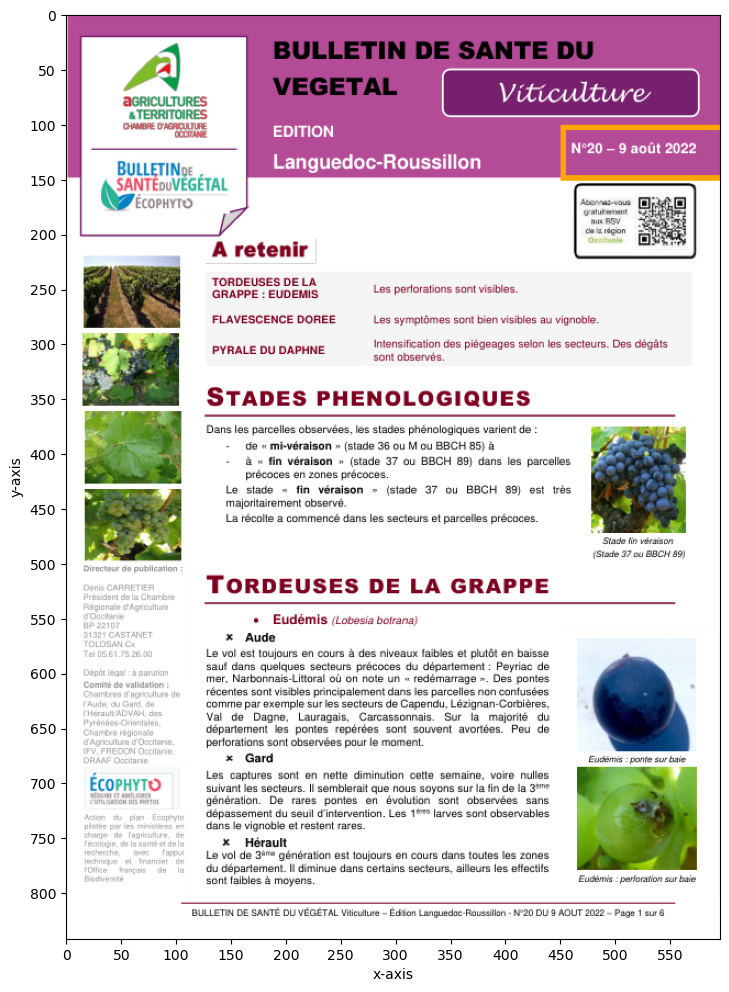

N°20 – 9 août 2022


In [8]:
import os
from PIL import Image, ImageDraw
import fitz
import matplotlib.pyplot as plt

def get_text_in_zone(page, coords, draw_rectangle=False):
    if draw_rectangle:
        x1, y1, x2, y2 = coords
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        draw = ImageDraw.Draw(img)

        draw.rectangle((x1, y1, x2, y2), outline="orange", width=5)

        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.xticks(range(0, pix.width, 50))
        plt.yticks(range(0, pix.height, 50))
        # plt.grid(True)
        plt.show()

    text = ""
    extracted_text = page.get_text("dict", sort=True, flags=fitz.TEXTFLAGS_TEXT)
    # Sort the blocks by their y-coordinates
    sorted_blocks = sorted(extracted_text["blocks"], key=lambda x: x["bbox"][1])

    for block in sorted_blocks:
        if block["type"] == 0:
            for line in block["lines"]:
                for span in line["spans"]:
                    span_bbox = span["bbox"]

                    if span_bbox[0] >= coords[0] and span_bbox[1] >= coords[1] and span_bbox[2] <= coords[2] and span_bbox[3] <= coords[3]:
                      if len(span["text"])>3:
                        text += span["text"] + " "
                      else:
                        text += span["text"]
                text = text.strip()

    return text.strip()

page = doc.load_page(0)
text = get_text_in_zone(page, (450, 100, 600, 150), draw_rectangle=True)
print(text)

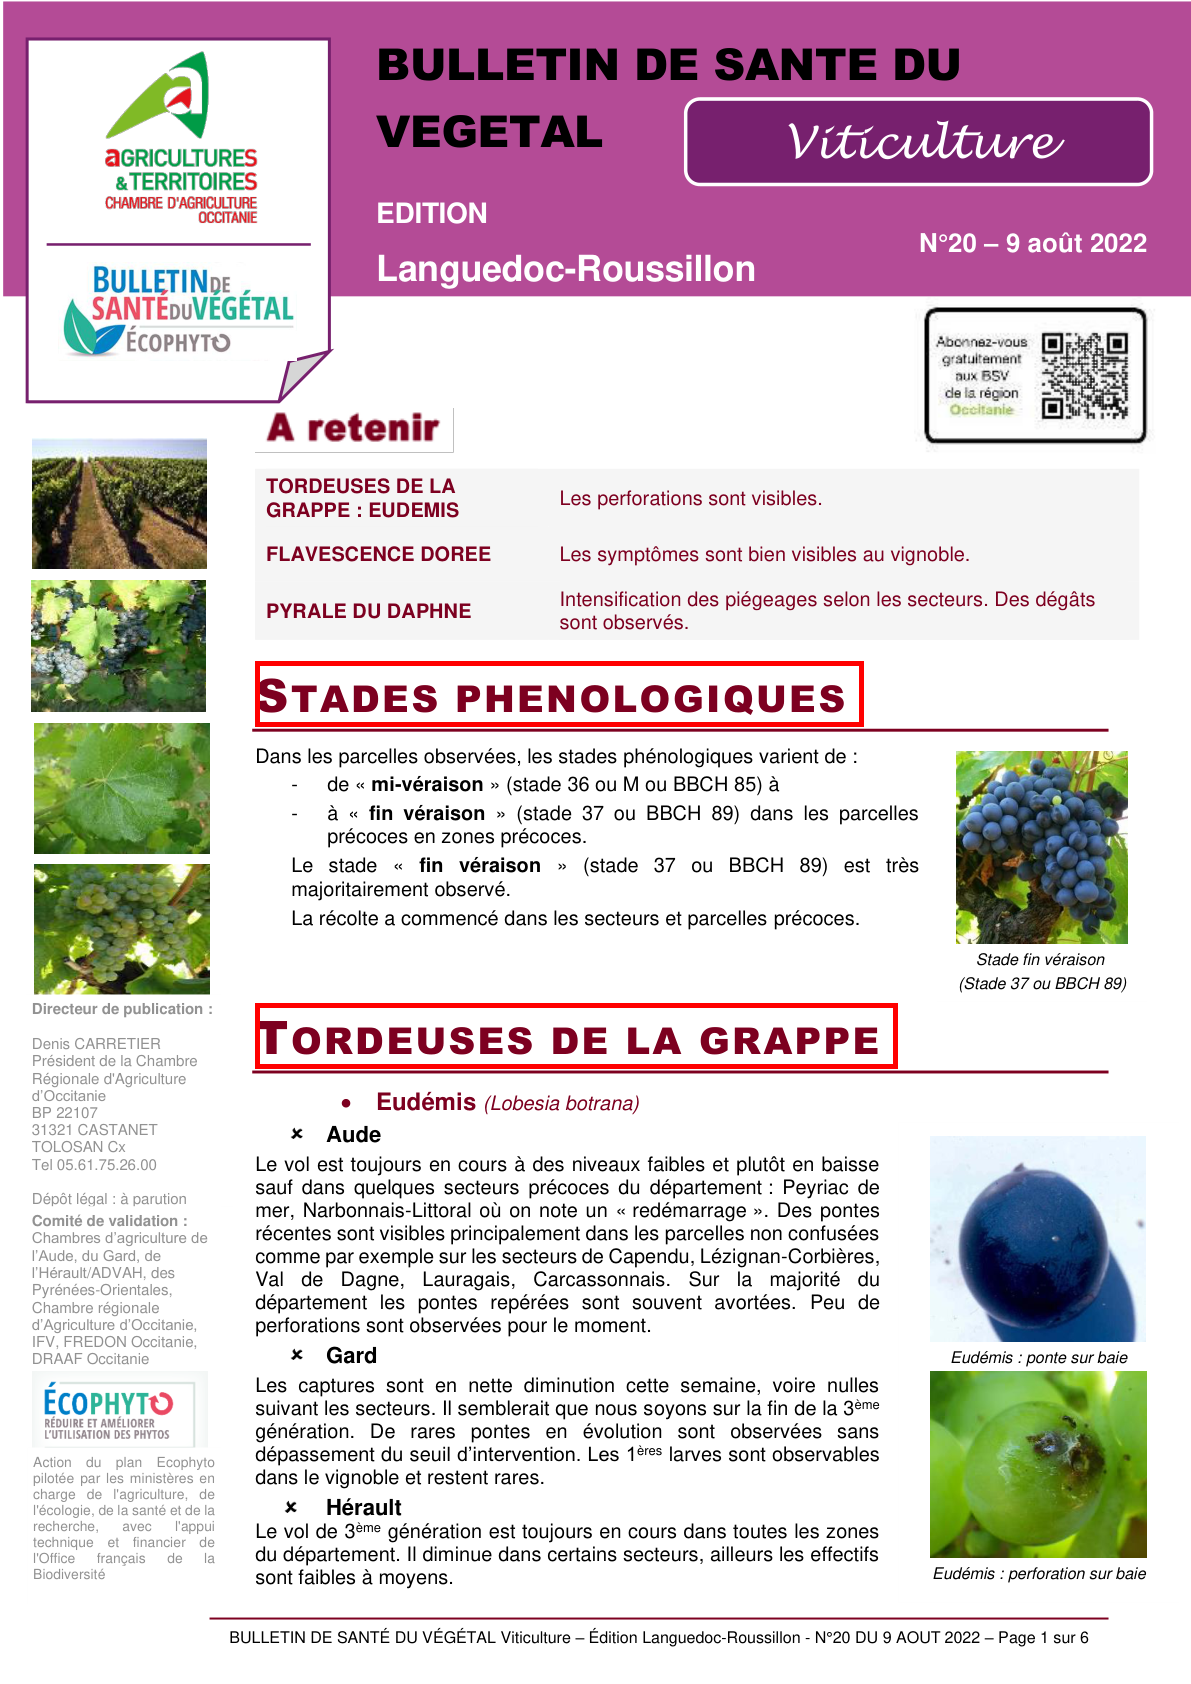

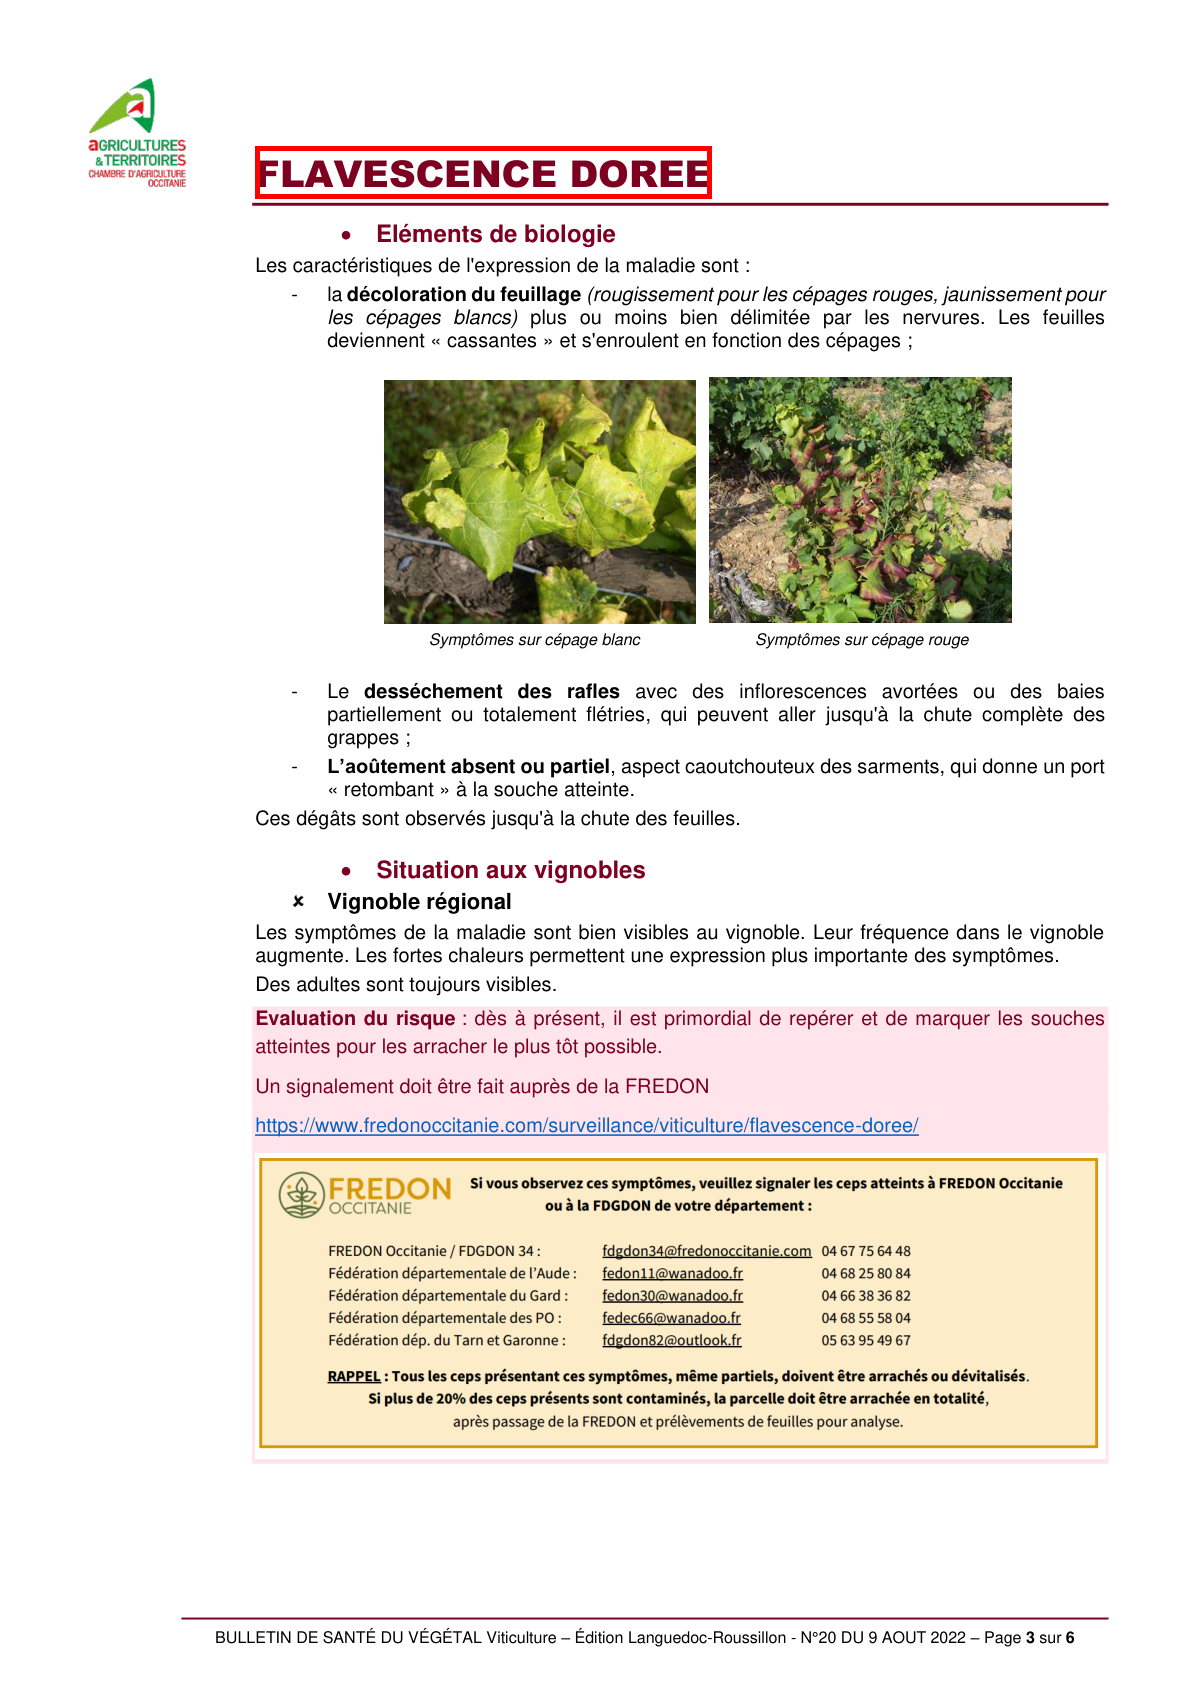

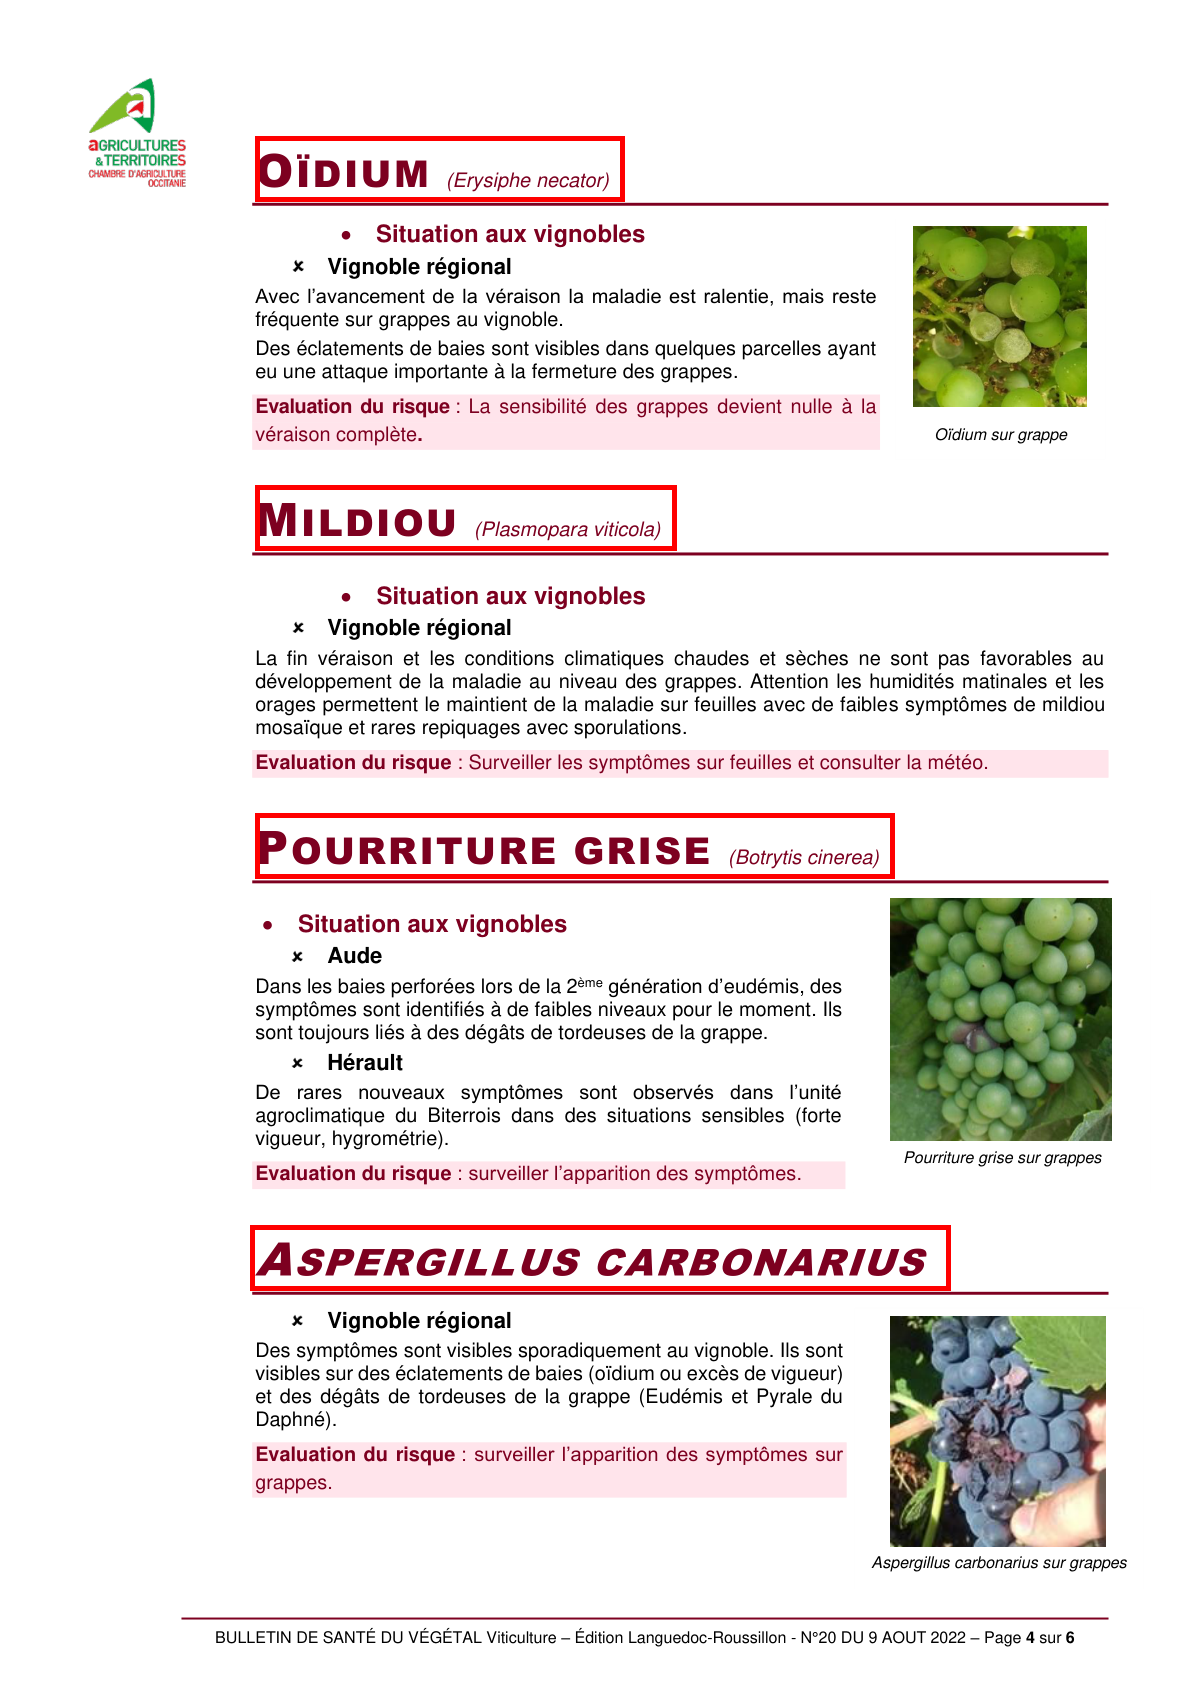

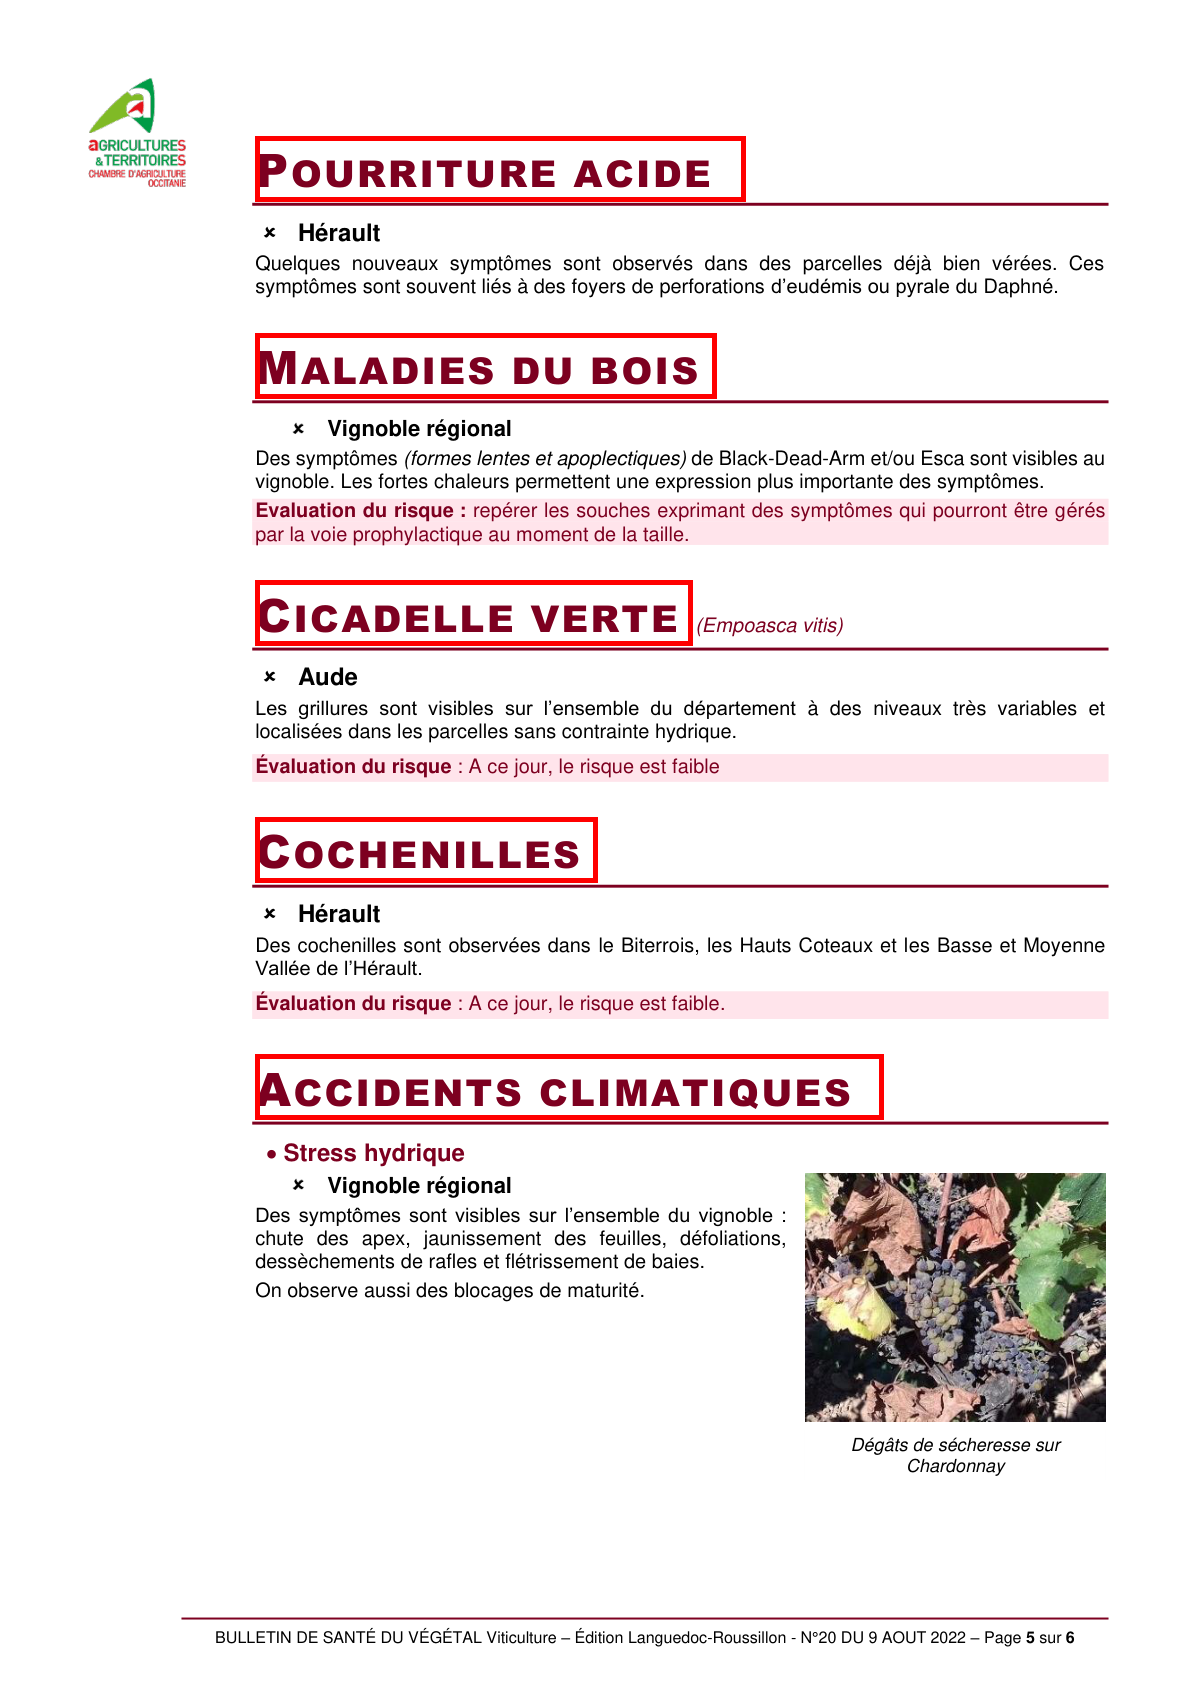

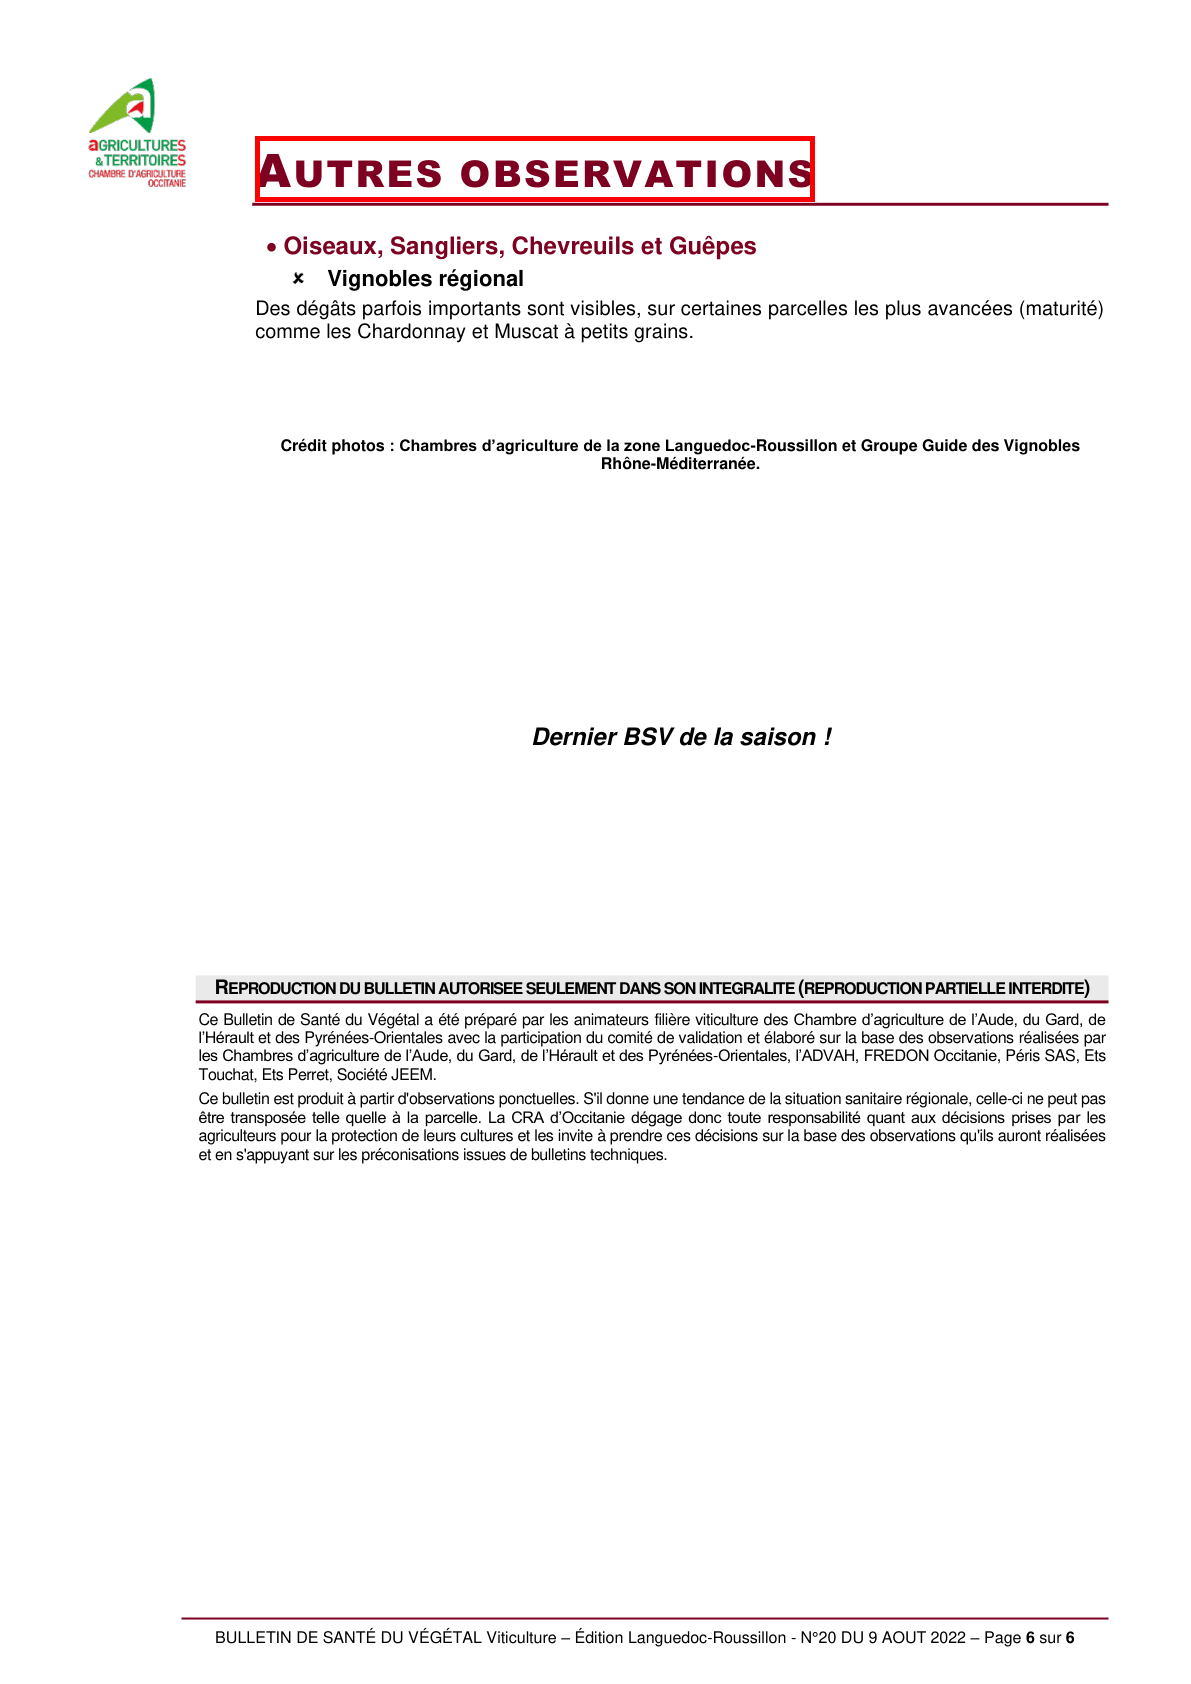

In [9]:
import os
from PIL import Image, ImageDraw
import fitz
import numpy as np

def draw_rectangles(page, bbox_coords, color="orange"):
    pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))

    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    draw = ImageDraw.Draw(img)

    # If bbox_coords is a single tuple, convert it to a list of one tuple
    if isinstance(bbox_coords, tuple):
        bbox_coords = [bbox_coords]

    for bbox in bbox_coords:
        scaled_bbox = [coord * 2 for coord in bbox]
        draw.rectangle(scaled_bbox, outline=color, width=5)

    return img
    
def merge_neighbor_bboxes(bbox_coords, threshold=50):
    def overlap_y(bbox1, bbox2):
        y1_1, y2_1 = bbox1[1], bbox1[3]
        y1_2, y2_2 = bbox2[1], bbox2[3]
        return (abs(y1_1 - y1_2) < threshold or abs(y1_1 - y2_2) < threshold) or \
               (abs(y2_1 - y1_2) < threshold or abs(y2_1 - y2_2) < threshold)

    def merge_bbox(bbox1, bbox2):
        return [min(bbox1[0], bbox2[0]), min(bbox1[1], bbox2[1]),
                max(bbox1[2], bbox2[2]), max(bbox1[3], bbox2[3])]

    merged = True
    while merged:
        merged = False
        new_bbox_coords = []
        merged_indices = []

        for i, bbox1 in enumerate(bbox_coords):
            if i in merged_indices:
                continue

            new_bbox = bbox1
            for j, bbox2 in enumerate(bbox_coords):
                if j in merged_indices or i == j:
                    continue

                if overlap_y(new_bbox, bbox2):
                    new_bbox = merge_bbox(new_bbox, bbox2)
                    merged = True
                    merged_indices.append(j)

            new_bbox_coords.append(new_bbox)

        bbox_coords = new_bbox_coords

    return bbox_coords

def process_sections(page, threshold = 50):
    saved_bbox = []
    bbox_coords = []
    identified_sections = []
    identified_sections_coords = []

    page_blocks = page.get_text("dict", sort=True, flags=fitz.TEXTFLAGS_TEXT)

    for block in page_blocks["blocks"]:
        if block["type"] == 0:
            for line in block["lines"]:
                for span in line["spans"]:
                    if span["size"] > 15 and span["color"] == 8192032:
                        saved_bbox.append(span["bbox"])
                        
    for s_bbox in saved_bbox:
        bbox_coords.append([coord for coord in s_bbox])

    bbox_coords = merge_neighbor_bboxes(bbox_coords, threshold)
    for bbox in bbox_coords:
      foo = [coord for coord in bbox]
      found_text = get_text_in_zone(page, foo, draw_rectangle=False)
      if len(found_text) > 2:
        identified_sections.append(found_text)
        identified_sections_coords.append(foo)
    return bbox_coords, identified_sections, identified_sections_coords

def process_document(pdf_path, output_dir="output_dict", draw_in_between_zones=False, display_image=False):
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
    os.makedirs(os.path.join(output_dir, pdf_name), exist_ok=True)
    image_path = os.path.join(output_dir, pdf_name)

    doc = fitz.open(pdf_path)
    
    identified_sections = []
    identified_sections_coords = []

    for page_num, page_i in enumerate(doc):
        pix = page_i.get_pixmap()
        bbox_coords, sections, coords = process_sections(page_i)

        identified_sections.extend(sections)
        identified_sections_coords.extend(coords)

        if len(bbox_coords) > 0:
            img = draw_rectangles(page_i, bbox_coords, color="RED")

            in_between_zones = []

            for i in range(len(coords)):
                zone_start = coords[i][3]  # y2 of the current section
                if i < len(coords) - 1:
                    zone_end = coords[i + 1][1]  # y1 of the next section
                else:
                    zone_end = pix.height/2  # bottom of the current page
                in_between_zones.append((coords[i][0]-10, zone_start + 5, pix.width/2, zone_end - 5))

            if page_num == len(doc) - 1:
                zone_start = coords[-1][3]  # y2 of the last section
                zone_end = pix.height/2  # bottom of the last page
                in_between_zones.append((0, zone_start + 5, pix.width/2, zone_end))

            if draw_in_between_zones:
                img = draw_rectangles(pix, in_between_zones, color="green")

            #image_name = f"page{page_num + 1}.png"
            #image_path_name = os.path.join(image_path, image_name)
            #img.save(image_path_name)
            if display_image:
                display(img)

            # for zone in in_between_zones:
              # text = get_text_in_zone(page, zone, draw_rectangle=False)
              # print(f"\n{text}\n")

    # Calculate in-between zones for the entire document
    # in_between_zones = []

    return identified_sections, identified_sections_coords, in_between_zones


# Processing : 
identified_sections, identified_sections_coords, in_between_zones = process_document(pdf_path, draw_in_between_zones=False, display_image=True)

In [10]:
print("Identified sections:")
for section in identified_sections:
    print(f"- {section}")

print("\nIdentified sections coordinates:")
for coord in identified_sections_coords:
    print(coord)

# print("\nIn-between zones:")
# for zone in in_between_zones:
#     print(zone)


Identified sections:
- STADES PHENOLOGIQUES
- TORDEUSES DE LA GRAPPE
- FLAVESCENCE DOREE
- OÏDIUM  (Erysiphe necator)
- MILDIOU  (Plasmopara viticola)
- POURRITURE GRISE  (Botrytis cinerea)
- ASPERGILLUS CARBONARIUS
- POURRITURE ACIDE
- MALADIES DU BOIS
- CICADELLE VERTE
- COCHENILLES
- ACCIDENTS CLIMATIQUES
- AUTRES OBSERVATIONS

Identified sections coordinates:
[127.58000183105469, 330.85247802734375, 431.833740234375, 363.3424987792969]
[127.58000183105469, 501.8724670410156, 448.66375732421875, 534.3624877929688]
[127.58000183105469, 73.04117584228516, 355.5862121582031, 99.10086059570312]
[127.58000183105469, 68.02250671386719, 312.41375732421875, 100.51250457763672]
[127.58000183105469, 242.8624725341797, 338.1137390136719, 275.35247802734375]
[127.58000183105469, 406.8124694824219, 447.3137512207031, 439.302490234375]
[125.2027359008789, 612.5125122070312, 475.4066162109375, 645.0025024414062]
[127.58000183105469, 68.02250671386719, 372.84539794921875, 100.51250457763672]
[127.5

## Extraction des contenus des sections grâce aux numéros de blocs intermédiaires

In [11]:
doc = fitz.open(pdf_path)

In [12]:
identified_sections, identified_sections_coords, in_between_zones = process_document(pdf_path, draw_in_between_zones=False)

In [13]:
def calculate_in_between_zones(page, section_A, section_B=None):

    if section_B == None:
        # Zone on last page from section_A to the bottom of the page
        return [(section_A[0], section_A[3], page.rect.width, page.rect.height - 40)]
        
    # If section_B is above section_A, it means we have moved to a new page
    if section_B[1] < section_A[3]:
        # Zone on page 1 from section_A to the bottom of the page
        zone1 = (section_A[0], section_A[3], page.rect.width, page.rect.height - 40)
        # Zone on page 2 from the top of the page to section_B
        zone2 = (section_B[0], 0, page.rect.width, section_B[1])
        
        return [zone1, zone2]
    else:
        # If we are on the same page, calculate the zone as before
        x1 = min(section_A[0], section_B[0])
        x2 = page.rect.width
        y1 = section_A[3]
        y2 = section_B[1]

        return [(x1, y1, x2, y2)]

In [14]:
identified_sections_coords

[[127.58000183105469, 330.85247802734375, 431.833740234375, 363.3424987792969],
 [127.58000183105469,
  501.8724670410156,
  448.66375732421875,
  534.3624877929688],
 [127.58000183105469, 73.04117584228516, 355.5862121582031, 99.10086059570312],
 [127.58000183105469,
  68.02250671386719,
  312.41375732421875,
  100.51250457763672],
 [127.58000183105469,
  242.8624725341797,
  338.1137390136719,
  275.35247802734375],
 [127.58000183105469, 406.8124694824219, 447.3137512207031, 439.302490234375],
 [125.2027359008789, 612.5125122070312, 475.4066162109375, 645.0025024414062],
 [127.58000183105469,
  68.02250671386719,
  372.84539794921875,
  100.51250457763672],
 [127.58000183105469, 166.78245544433594, 358.15374755859375, 199.2724609375],
 [127.58000183105469, 290.4124450683594, 346.1423034667969, 322.9024658203125],
 [127.58000183105469,
  408.85247802734375,
  298.9737548828125,
  441.3424987792969],
 [127.58000183105469, 527.4324951171875, 441.6737365722656, 559.9224853515625],
 [127.

In [15]:
temp = {}
j = 0
for i in range(len(identified_sections_coords)-1):
    page = doc.load_page(j)
    
    zones = calculate_in_between_zones(page, identified_sections_coords[i], identified_sections_coords[i+1])
    print(zones)
    
    if j not in temp:
        temp[j] = []
        temp[j].append(zones[0])
    else:
        temp[j].append(zones[0])
    if len(zones) > 1:
        j += 1
        temp[j] = []
        temp[j].append(zones[1])
    
#a,b,c,d = calculate_in_between_zones(page, identified_sections_coords[-1])[0]
#temp[len(doc)-1].append((a,b,c,d-150))
display(temp)

[(127.58000183105469, 363.3424987792969, 595.3200073242188, 501.8724670410156)]
[(127.58000183105469, 534.3624877929688, 595.3200073242188, 801.9199829101562), (127.58000183105469, 0, 595.3200073242188, 73.04117584228516)]
[(127.58000183105469, 99.10086059570312, 595.3200073242188, 801.9199829101562), (127.58000183105469, 0, 595.3200073242188, 68.02250671386719)]
[(127.58000183105469, 100.51250457763672, 595.3200073242188, 242.8624725341797)]
[(127.58000183105469, 275.35247802734375, 595.3200073242188, 406.8124694824219)]
[(125.2027359008789, 439.302490234375, 595.3200073242188, 612.5125122070312)]
[(125.2027359008789, 645.0025024414062, 595.3200073242188, 801.9199829101562), (127.58000183105469, 0, 595.3200073242188, 68.02250671386719)]
[(127.58000183105469, 100.51250457763672, 595.3200073242188, 166.78245544433594)]
[(127.58000183105469, 199.2724609375, 595.3200073242188, 290.4124450683594)]
[(127.58000183105469, 322.9024658203125, 595.3200073242188, 408.85247802734375)]
[(127.580001

{0: [(127.58000183105469,
   363.3424987792969,
   595.3200073242188,
   501.8724670410156),
  (127.58000183105469,
   534.3624877929688,
   595.3200073242188,
   801.9199829101562)],
 1: [(127.58000183105469, 0, 595.3200073242188, 73.04117584228516),
  (127.58000183105469,
   99.10086059570312,
   595.3200073242188,
   801.9199829101562)],
 2: [(127.58000183105469, 0, 595.3200073242188, 68.02250671386719),
  (127.58000183105469,
   100.51250457763672,
   595.3200073242188,
   242.8624725341797),
  (127.58000183105469,
   275.35247802734375,
   595.3200073242188,
   406.8124694824219),
  (125.2027359008789, 439.302490234375, 595.3200073242188, 612.5125122070312),
  (125.2027359008789,
   645.0025024414062,
   595.3200073242188,
   801.9199829101562)],
 3: [(127.58000183105469, 0, 595.3200073242188, 68.02250671386719),
  (127.58000183105469,
   100.51250457763672,
   595.3200073242188,
   166.78245544433594),
  (127.58000183105469, 199.2724609375, 595.3200073242188, 290.4124450683594),


0 [(127.58000183105469, 363.3424987792969, 595.3200073242188, 501.8724670410156), (127.58000183105469, 534.3624877929688, 595.3200073242188, 801.9199829101562)]


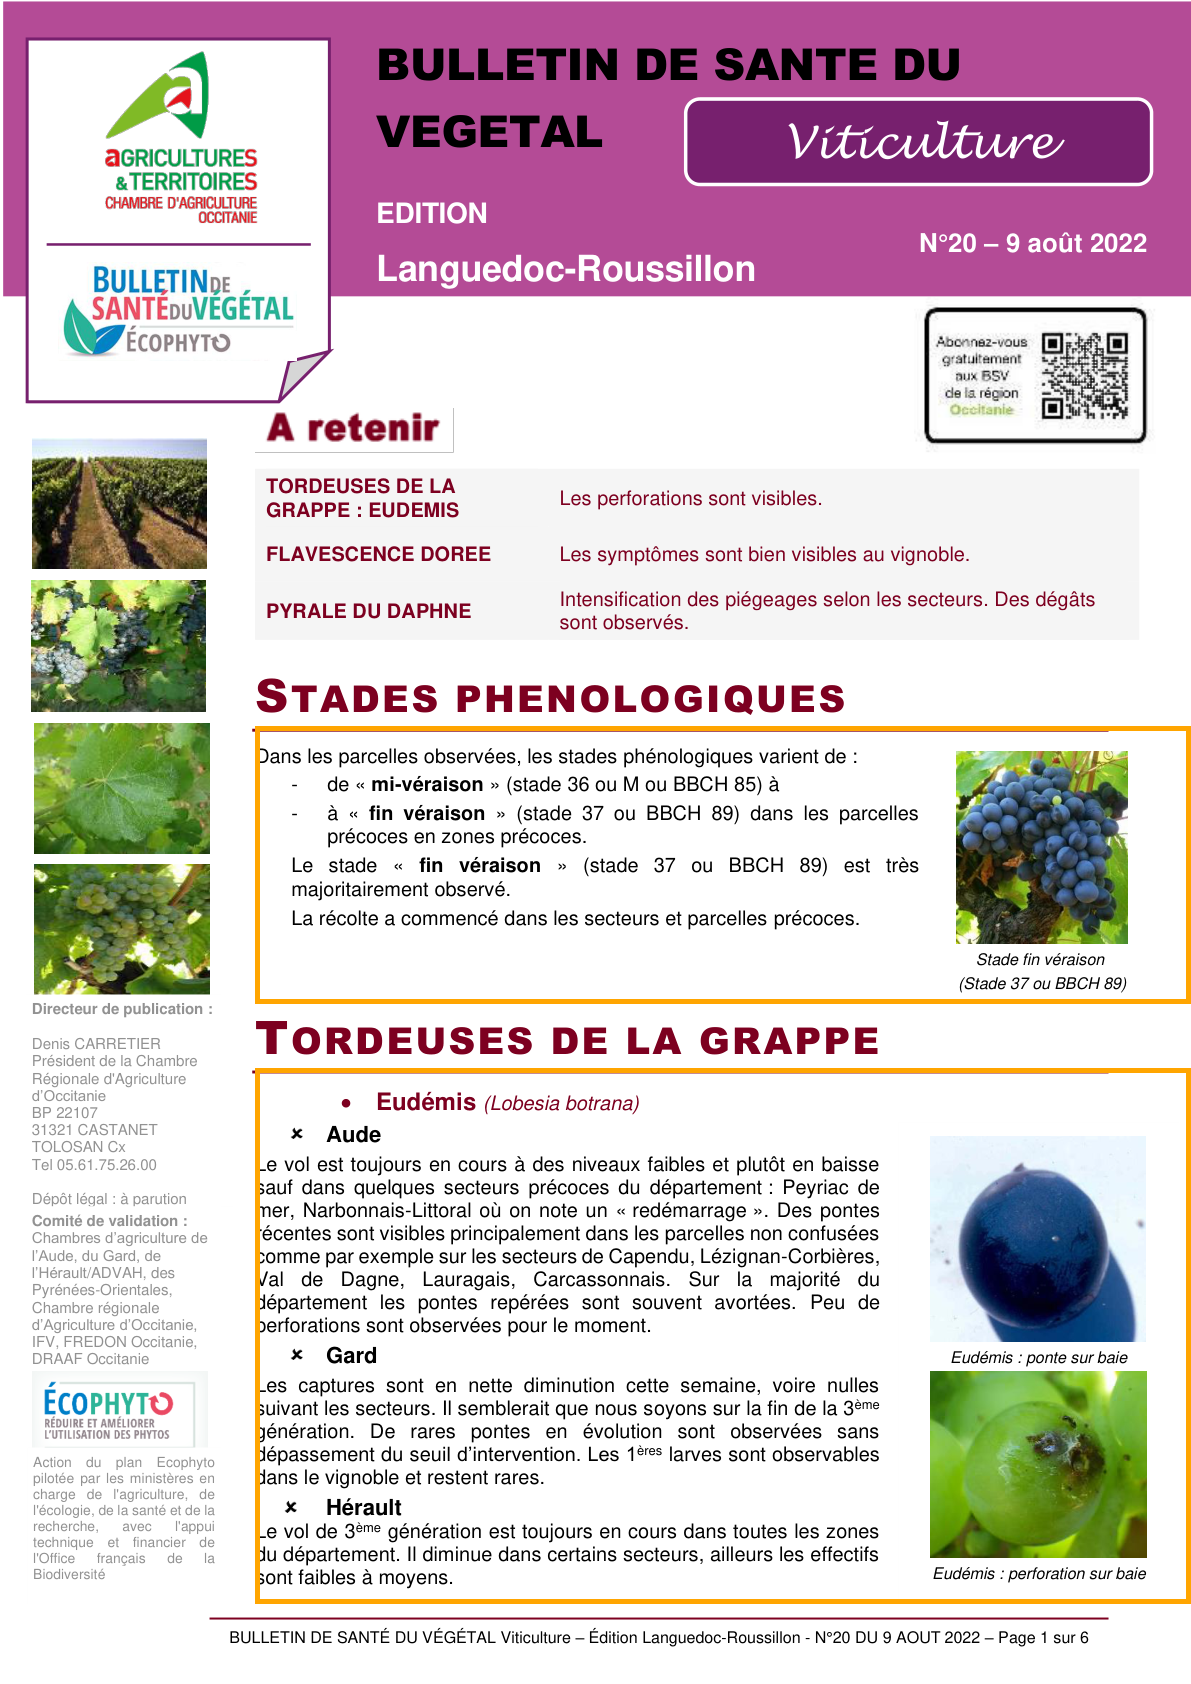

1 [(127.58000183105469, 0, 595.3200073242188, 73.04117584228516), (127.58000183105469, 99.10086059570312, 595.3200073242188, 801.9199829101562)]


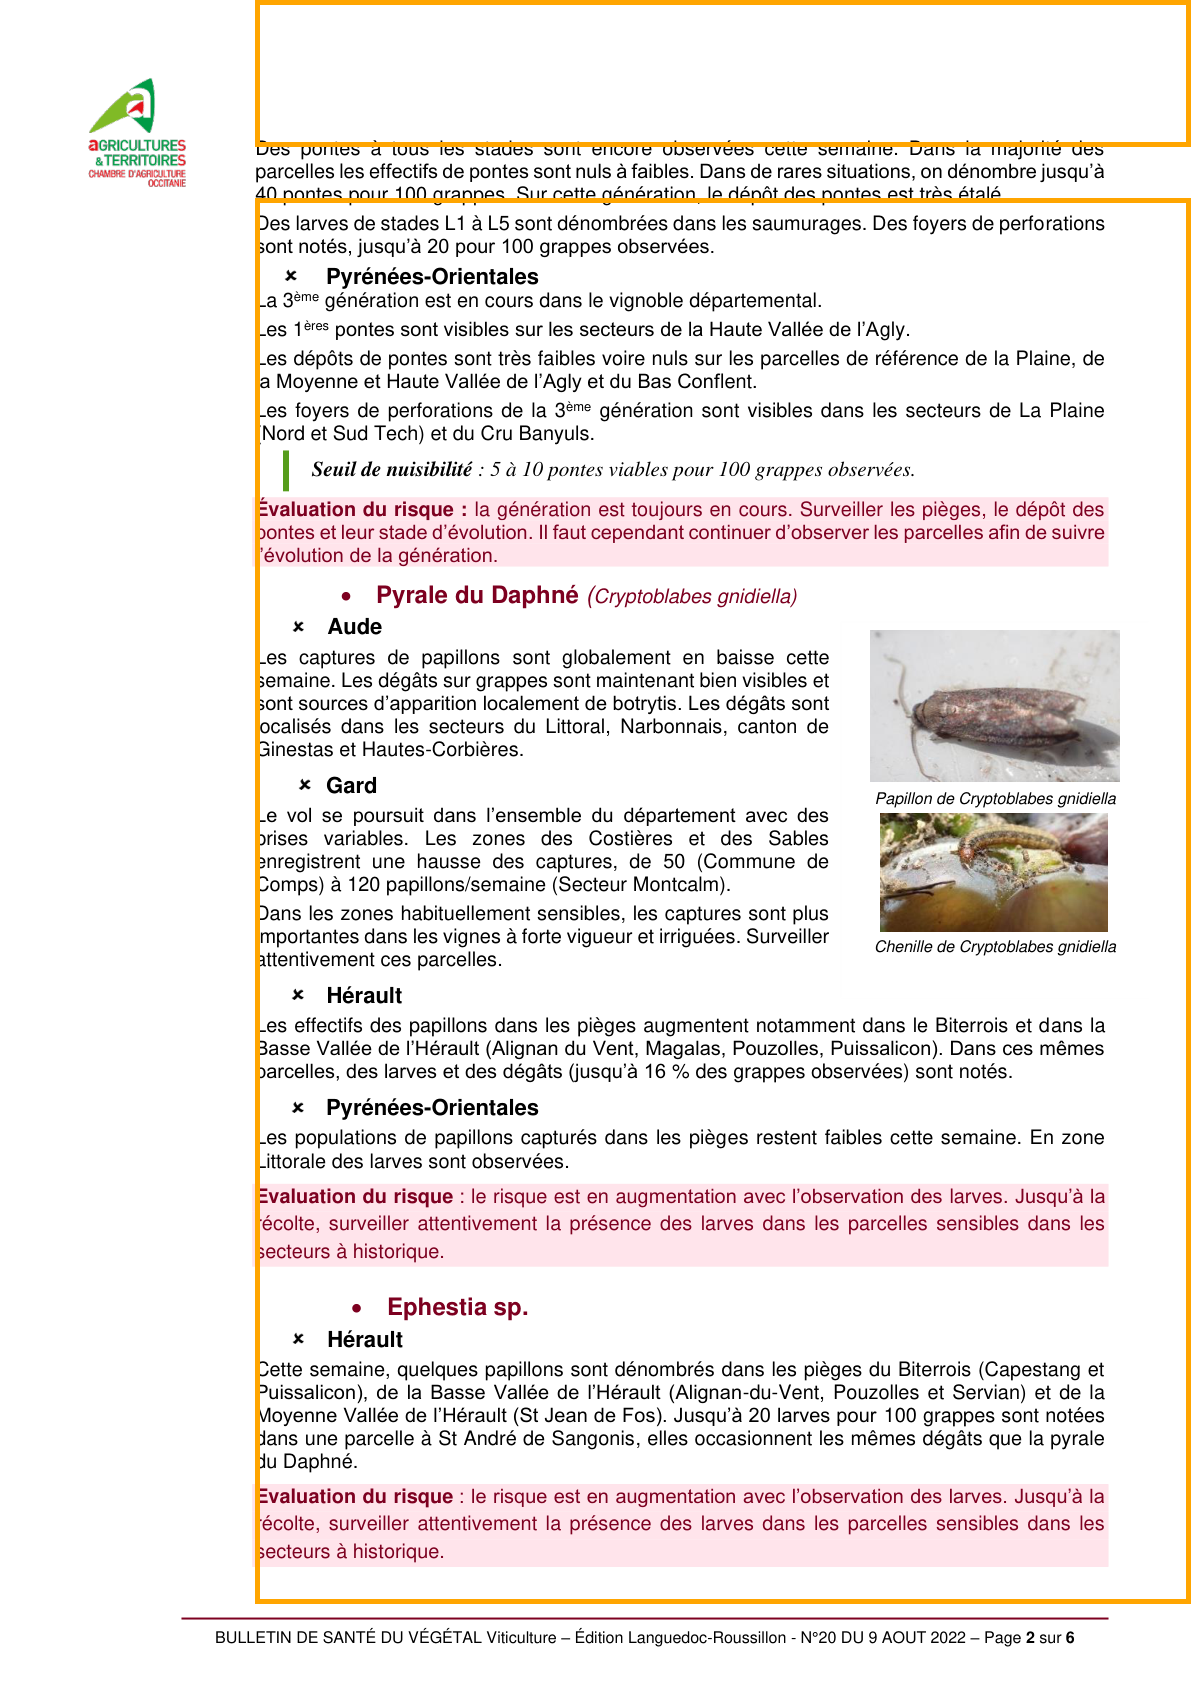

2 [(127.58000183105469, 0, 595.3200073242188, 68.02250671386719), (127.58000183105469, 100.51250457763672, 595.3200073242188, 242.8624725341797), (127.58000183105469, 275.35247802734375, 595.3200073242188, 406.8124694824219), (125.2027359008789, 439.302490234375, 595.3200073242188, 612.5125122070312), (125.2027359008789, 645.0025024414062, 595.3200073242188, 801.9199829101562)]


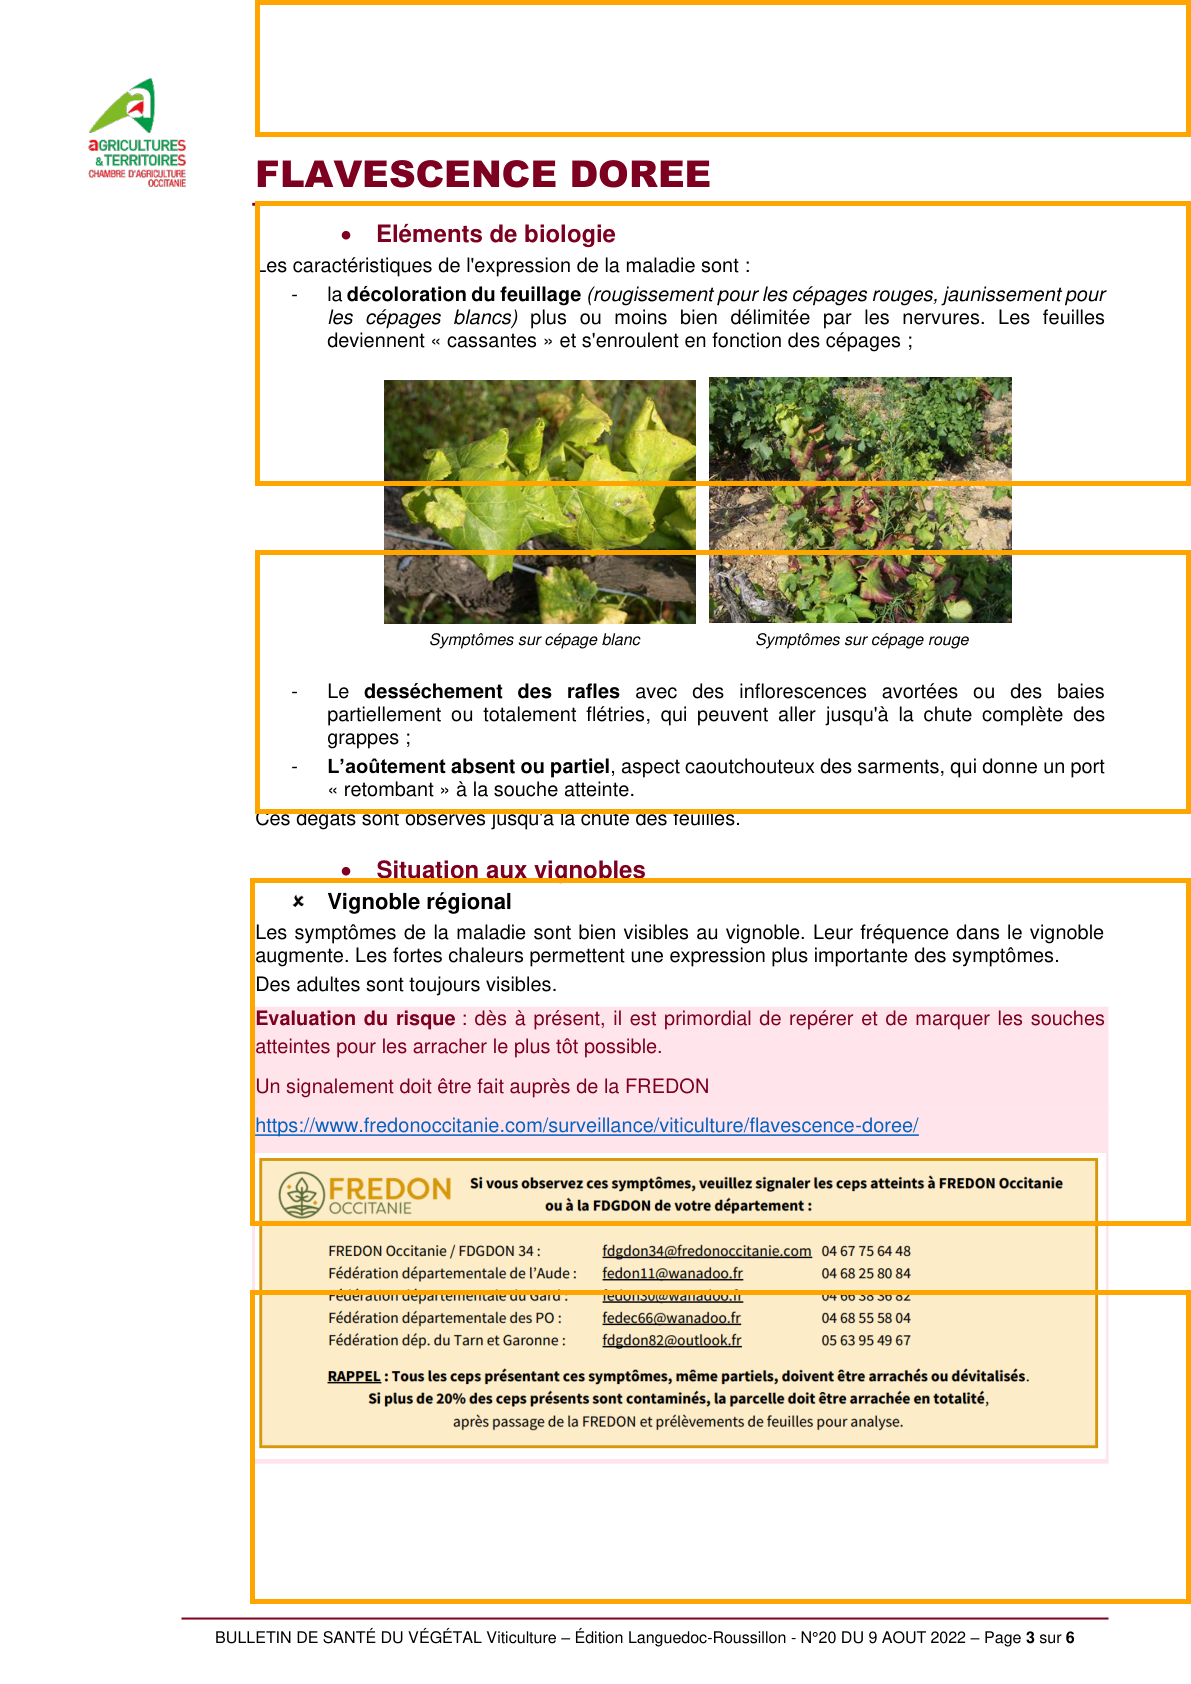

3 [(127.58000183105469, 0, 595.3200073242188, 68.02250671386719), (127.58000183105469, 100.51250457763672, 595.3200073242188, 166.78245544433594), (127.58000183105469, 199.2724609375, 595.3200073242188, 290.4124450683594), (127.58000183105469, 322.9024658203125, 595.3200073242188, 408.85247802734375), (127.58000183105469, 441.3424987792969, 595.3200073242188, 527.4324951171875), (127.58000183105469, 559.9224853515625, 595.3200073242188, 801.9199829101562)]


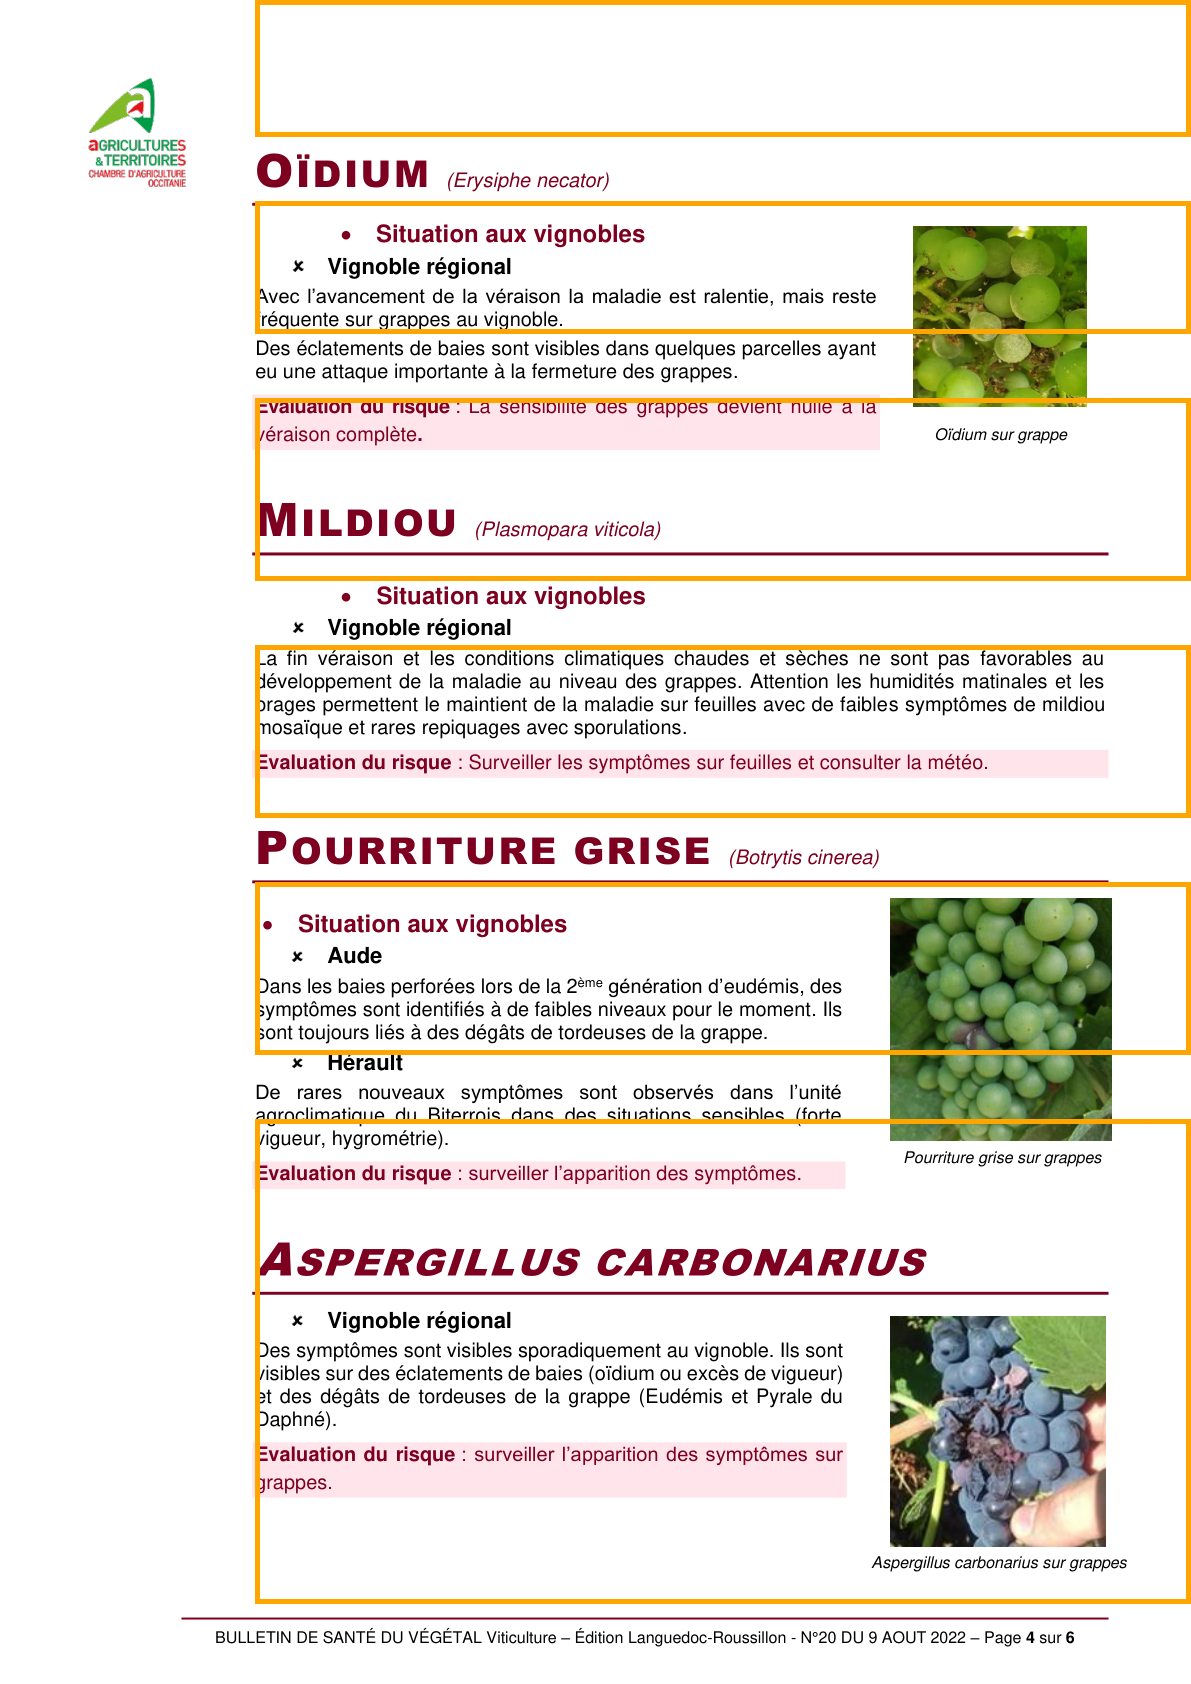

4 [(127.58000183105469, 0, 595.3200073242188, 68.02250671386719)]


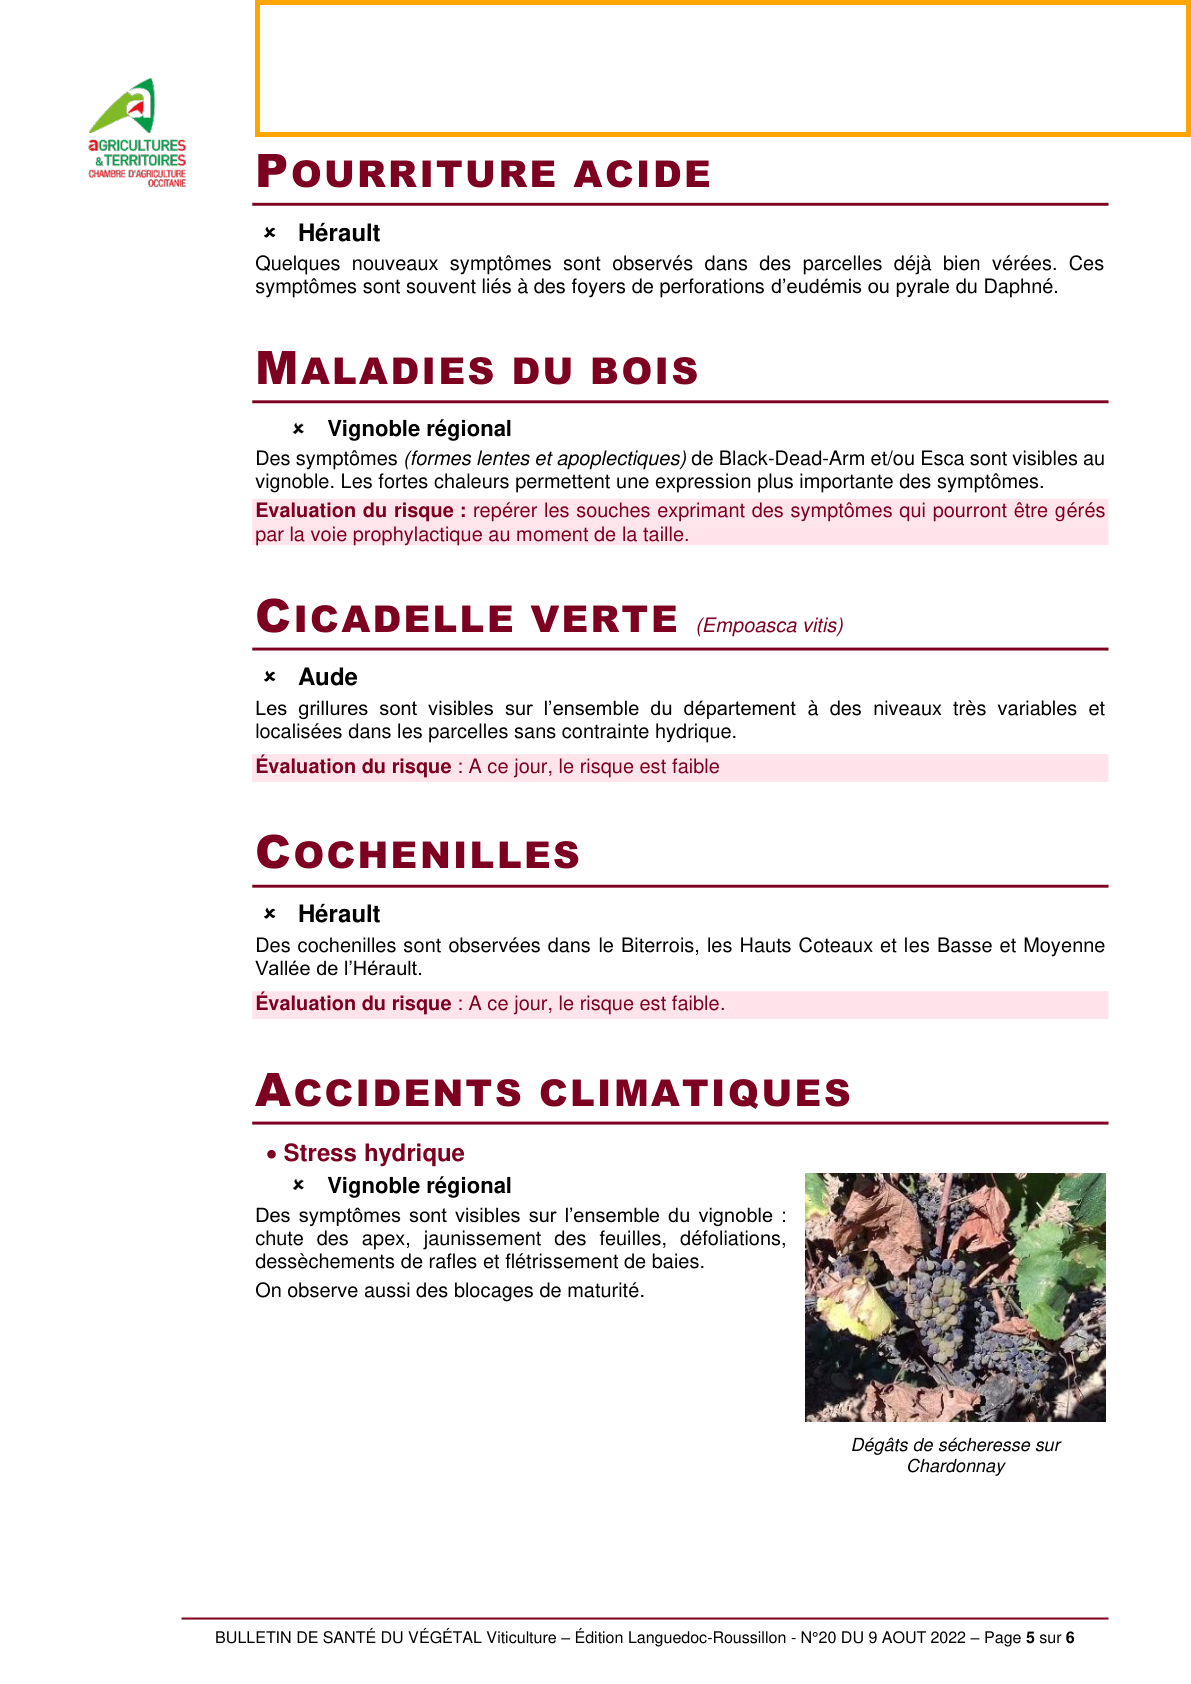

In [16]:
for key, value in temp.items():
    print(key, value)
    page = doc.load_page(key)
    img = draw_rectangles(page, value, color="orange")
    display(img)

## Identification des sections de tous les PDF d'un repertoire

In [17]:
import os
import glob
# Set the path of the folder containing PDF files
#folder_path = "/content/unibsv/data/UniBSV/BSV Languedoc-Roussillon"
folder_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon"

global_sections_list = []

# Use the glob module to find all PDF files in the folder
pdf_files = glob.glob(os.path.join(folder_path, "*.pdf"))

# Loop through each PDF file
for pdf_file in pdf_files:
    # Do something with the PDF file
    print(f"*** Document : {pdf_file} ***\n")
    identified_sections, identified_sections_coords, in_between_zones = process_document(pdf_file, draw_in_between_zones=False)

    global_sections_list.extend(identified_sections)
    
    print("Identified sections:")
    for section in identified_sections:
        print(f"- {section}")
    print("\n")

*** Document : unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N17_19072022.pdf ***

Identified sections:
- PLUVIOMETRIE
- STADES PHENOLOGIQUES
- FLAVESCENCE DOREE
- OÏDIUM  (Erysiphe necator)
- TORDEUSES DE LA GRAPPE
- MILDIOU  (Plasmopara viticola)
- POURRITURE GRISE  (Botrytis cinerea)
- ASPERGILLUS CARBONARIUS
- BLACK ROT  (Guignardia bidwellii)
- MALADIE DU BOIS
- CICADELLE VERTE
- ACCIDENTS CLIMATIQUES


*** Document : unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N16_05072022.pdf ***

Identified sections:
- PLUVIOMETRIE
- STADES PHENOLOGIQUES
- FLAVESCENCE DOREE
- OÏDIUM  (Erysiphe necator)
- TORDEUSES DE LA GRAPPE
- MILDIOU  (Plasmopara viticola)
- POURRITURE GRISE  (Botrytis cinerea)
- BLACK ROT  (Guignardia bidwellii)
- MALADIE DU BOIS
- CICADELLE VERTE
- COCHENILLES
- METCALFA PRUINOSA
- ACCIDENTS CLIMATIQUES


*** Document : unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N15_28062022.pdf ***

Identified sections:
- PLUVIOMETRIE
- STADES PHENOLOGIQ

In [18]:
# duplicates removal
my_list = sorted(set(global_sections_list))
display(my_list)

['ACARIENS',
 'ACCIDENT CLIMATIQUE',
 'ACCIDENT PHYSIOLOGIQUE',
 'ACCIDENTS CLIMATIQUES',
 'ASPERGILLUS CARBONARIUS',
 'AUTRES OBSERVATIONS',
 'BLACK ROT  (Guignardia bidwellii)',
 'CICADELLE VERTE',
 'CICADELLE VERTE  (Empoasca vitis)',
 'CICADELLEVECTRICEDELAFLAVESCENCE DOREE  (Scaphoideus titanus)',
 'COCCINELLE',
 'COCHENILLES',
 'DONNEES DE LA MODELISATION DANS LESBSV VIGNECARACTERISTIQUES DES MODELES',
 'ERINOSE',
 'EUTYPIOSE',
 'EXCORIOSE  (Phomopsis viticola)',
 'FLAVESCENCE DOREE',
 'FOCUS XYLELLA FASTIDIOSA',
 'MALADIE DU BOIS',
 'MALADIES DU BOIS',
 'METCALFA PRUINOSA',
 'MILDIOU  (Plasmopara viticola)',
 'NECROSE BACTERIENNE  (Xylophilus ampelinus)',
 'OÏDIUM  (Erysiphe necator)',
 'PLUVIOMETRIE',
 'POURRITURE ACIDE',
 'POURRITURE GRISE',
 'POURRITURE GRISE  (Botrytis cinerea)',
 'RAVAGEURS SECONDAIRES',
 'RAVAGEURSSECONDAIRES',
 'STADES PHENOLOGIQUES',
 'Stade « baies à taille de grains de plomb »(stade 29 ou BBCH 73)CICADELLEVECTRICEDELAFLAVESCENCE DOREE  (Scaphoideus tit

## Sandbox

In [19]:
import logging
import os
import random

from fitz import fitz, Pixmap

from unibsv.preprocess import detect_tables

def visualize_blocks(file_path: str, output_dir: str) -> list[str]:
    """
    Render PDF pages as images with highlighted blocks, lines and drawings, to provide a way to understand page layouts.
    :param file_path: PDF source file
    :param output_dir: where images should be written
    :return: the paths of the generated images
    """
    images = []

    with fitz.open(file_path) as doc:
        for page in doc:  # iterate through the pages
            pix: Pixmap = page.get_pixmap()  # render page to an image

            # drawings
            page_drawings = page.get_drawings()
            for i in range(len(page_drawings)):
                #color = (random.randint(100, 250), random.randint(100, 250), random.randint(100, 250))
                color = (255,0,0)
                bbox = page_drawings[i]["rect"]
                draw_bbox(pix, bbox, color, fill=True)

            # blocks & lines
            page_blocks = page.get_text("dict", sort=True)["blocks"]
            for i in range(len(page_blocks)):
                block = page_blocks[i]
                #color = (100 + int(i * 155 / len(page_blocks)), 50, 50)
                color = (0,255,0)
                draw_bbox(pix, block["bbox"], color)
                if "lines" in block:
                    for line_idx, line in enumerate(block["lines"]):
                        draw_bbox(pix, line["bbox"], (50, 50, 100 + int(i * 155 / len(page_blocks))), 2)

            # resolved tables
            tables = detect_tables(page)
            logging.debug(f"resolved {len(tables)} table(s) for page {page.number}")
            for i in range(len(tables)):
                #color = (50, 50, 100 + int(i * 155 / len(tables)))
                color = (0,0,255)
                for line in tables[i]:
                    for cell in line:
                        draw_bbox(pix, cell, color, 7)

            output_image = os.path.join(output_dir, f"{os.path.basename(doc.name)}-{page.number}.png")
            pix.save(output_image)  # store image as a PNG
            images.append(output_image)
    return images


def draw_bbox(pix, bbox, color, dashed: int = 0, fill: bool = False):
    """
    Draw a bounding box of the given color.
    :param pix: the Pixmap to draw to
    :param bbox: the bounding box to draw
    :param color: the color to use
    :param dashed: the length of dashes, if any
    :param fill: if an inner margin of the box should be colored
    """
    # clip the given box to the pixmap dimensions
    x0 = max(0, int(min(bbox[0], bbox[2])))
    y0 = max(0, int(min(bbox[1], bbox[3])))
    x1 = min(pix.width - 1, int(max(bbox[0], bbox[2])))
    y1 = min(pix.height - 1, int(max(bbox[1], bbox[3])))
    i = 0
    # draw horizontal lines
    for x in range(x0, x1):
        if dashed > 0:
            i += 1
            if int(i / dashed) % 2 == 1:
                continue
        pix.set_pixel(x, y0, color)
        pix.set_pixel(x, y1, color)
    # draw vertical lines
    for y in range(y0, y1):
        if dashed > 0:
            i += 1
            if int(i / dashed) % 2 == 1:
                continue
        pix.set_pixel(x0, y, color)
        pix.set_pixel(x1, y, color)

    # fill an inner margin of 1 to 4 pixels wide
    if fill and x1 - x0 > 2 and y1 - y0 > 2:
        for i in range(1, min(4, int((x1 - x0) / 2))):
            for j in range(1, min(4, int((y1 - y0) / 2))):
                draw_bbox(pix, (x0 + i, y0 + j, x1 - i, y1 - j), color, dashed, fill=False)

visualize_blocks(pdf_path, "/home/medo/miniconda/UniBSV/testoo")

['/home/medo/miniconda/UniBSV/testoo/BSV_VITI_LR_N20_09082022.pdf-0.png',
 '/home/medo/miniconda/UniBSV/testoo/BSV_VITI_LR_N20_09082022.pdf-1.png',
 '/home/medo/miniconda/UniBSV/testoo/BSV_VITI_LR_N20_09082022.pdf-2.png',
 '/home/medo/miniconda/UniBSV/testoo/BSV_VITI_LR_N20_09082022.pdf-3.png',
 '/home/medo/miniconda/UniBSV/testoo/BSV_VITI_LR_N20_09082022.pdf-4.png',
 '/home/medo/miniconda/UniBSV/testoo/BSV_VITI_LR_N20_09082022.pdf-5.png']

In [20]:
pdf_path

'unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N20_09082022.pdf'

In [21]:
import logging
from argparse import ArgumentParser
from logging import getLevelName, DEBUG, INFO, WARN
from pathlib import Path

import fitz
from ruamel.yaml import dump

from unibsv.debug import visualize_blocks
from unibsv.preprocess import read_pdf
#from unibsv.process import process, Report, write_report

from bigtree import shift_nodes, Node, yield_tree, findall

In [ ]:
from unibsv.configuration import get_config
get_config("configuration.yaml")

{'regions': ['Alsace',
  'Auvergne-Rhône-Alpes',
  'Bourgogne-Franche-Comté',
  'Champagne',
  'Languedoc-Roussillon',
  'Nouvelle-Aquitaine',
  'PACA'],
 'location_titles': ['Territoire', 'Vignoble', 'Département'],
 'locations': ['Secteur',
  'Nord Aquitaine',
  'Sud Drôme',
  'Côtes du Rhône',
  'Vallée du Rhône',
  'Sud Luberon',
  'Bouches du Rhône',
  'Ste Victoire',
  'Provence',
  'Saône et Loire',
  "Côte d'Or",
  'Yonne',
  'Nièvre',
  'Franche Comté',
  'Aude',
  'Gard',
  'Hérault',
  'Pyrénées-Orientales',
  'Beaujolais',
  'Coteaux du Lyonnais',
  'Forez',
  'Roannais',
  'Côtes du Rhône nord',
  'Diois',
  'Savoie',
  'Bugey',
  'Balmes dauphinoises',
  'Sud Ardèche'],
 'stage_titles': ['stades végétatifs', 'stades phénologiques', 'phénologie'],
 'stages': ['stade',
  'baies',
  'fleur',
  'fermeture',
  'floraison',
  'nouaison',
  'grain',
  'récolte',
  'véraison'],
 'pests': ['Mildiou',
  'Oïdium',
  'Black-rot',
  'Blackrot',
  'Botrytis',
  'Pourriture grise',
  'M

In [23]:
pdf = read_pdf(pdf_path)

In [24]:
from bigtree import Node, tree_to_dot, print_tree
print_tree(pdf, attr_list=["text"])
#print_tree(pdf, all_attrs=True)

BSV_VITI_LR_N20_09082022.pdf [text=None]
└── single-page-merged [text=None]
    ├── line-0.1.0-line-0.2.0 [text=BULLETIN DE SANTE DU VEGETAL ]
    ├── line-0.2.1 [text=Viticulture ]
    │   ├── img-0.3 [text=None]
    │   ├── line-0.4.0 [text=EDITION ]
    │   │   └── line-0.5.0 [text=N°20 – 9 août 2022 ]
    │   └── line-0.6.0 [text=Languedoc-Roussillon ]
    │       ├── img-0.7 [text=None]
    │       ├── img-0.11 [text=None]
    │       ├── img-0.12 [text=None]
    │       ├── line-0.13.0-line-0.14.1 [text=TORDEUSES DE LA GRAPPE : EUDEMIS Les perforations sont visibles. FLAVESCENCE DOREE Les symptômes sont bien visibles au vignoble. ]
    │       │   └── img-0.15 [text=None]
    │       └── line-0.16.0-line-0.16.2 [text=PYRALE DU DAPHNE Intensification des piégeages selon les secteurs. Des dégâts sont observés. ]
    │           └── img-0.17 [text=None]
    ├── line-0.18.0 [text=STADES PHENOLOGIQUES ]
    │   ├── line-0.19.0-line-0.21.2 [text=Dans les parcelles observées, les stades

line-0.6.0 [image=None, labels={'node_type': 'LINE'}, metadata={'wmode': 0, 'dir': (1.0, 0.0), 'bbox': (220.75, 232.6699981689453, 495.6280212402344, 257.45599365234375), 'block_idx': 6, 'font': 'Arial', 'size': 18.0}, table=None, text=AU SOMMAIRE DE CE NUMÉRO]


In [25]:
from unidecode import unidecode
from bigtree import Node, preorder_iter, postorder_iter, levelorder_iter, levelordergroup_iter

folder_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon"

# Use the glob module to find all PDF files in the folder
pdf_files = glob.glob(os.path.join(folder_path, "*.pdf"))

risk_corpus = []
for pdf_path in pdf_files:
    pdf = read_pdf(pdf_path)

    for node in preorder_iter(pdf):
        if node.text != None and "du risque" in node.text.lower():
#            print('_________FOUND ONE ________')
            start_phrase = "evaluation du risque :"
            start_index = unidecode(node.text.lower()).find(start_phrase)

            if start_index != -1:
                #print(node.parent.text)
                extracted_sentence = node.text[(start_index+len(start_phrase)):].strip()
 #               print(extracted_sentence)
                risk_corpus.append(extracted_sentence)

modélisé" from line "modélisé "
g
sur l’ensemble de la région." from line "sur l’ensemble de la région. "
p
météorologiques annoncées pour le" from line "météorologiques annoncées pour le "
p
moment, aucune contamination n’est à" from line "moment, aucune contamination n’est à "
modélisé" from line "modélisé "
de la région. Seul le Gard reste" from line "de la région. Seul le Gard reste "
majoritairement en risque faible excepté un" from line "majoritairement en risque faible excepté un "
la région." from line "la région. "
q
été détectées sur les pluies du :" from line "été détectées sur les pluies du : "
Limouxin, Malepère," from line "Limouxin, Malepère,  "
Hautes Corbières, Limouxin, Basse Vallée" from line "Hautes Corbières, Limouxin, Basse Vallée "
,
de l’Hérault, Hauts Coteaux, Vallée de l’Orb," from line "de l’Hérault, Hauts Coteaux, Vallée de l’Orb, "
q
annoncées sur les pluies" from line "annoncées sur les pluies "
Banyuls" from line "Banyuls "
Sud Tech" from line "Sud Tech  

In [26]:
risk_corpus

['le 3ème traitement contre le vecteur de la flavescence dorée, rendu obligatoire par arrêté préfectoral, est à réaliser dans la période du 15 au 25 juillet 2022. Pour toute information, consulter le site de la DRAAF Occitanie ainsi que les arrêtés préfectoraux relatifs aux traitements obligatoires.',
 'la période de sensibilité à l’oïdium est toujours en cours dans les parcelles les plus tardives mais la sensibilité de la vigne à la maladie décroît jusqu’à véraison complète des grappes. Surveiller les symptômes notamment sur baies.',
 'surveillez les pièges, les dépôts des pontes, et leurs stades d’évolution.',
 'le risque est en augmentation avec l’observation des larves. Surveiller les vols et les larves.',
 'Le risque de subir des dégâts sur baie régresse progressivement à partir de la fermeture de grappe. Surveiller les symptômes et consulter la météo.',
 'surveiller l’apparition des symptômes notamment sur grappes.',
 'surveiller l’apparition des symptômes sur grappes.',
 'Les co

In [2]:
import pickle

In [27]:
# Specify the file path to save the array
output_file = 'risk_corpus.pkl'

# Save the array to the file
with open(output_file, 'wb') as f:
    pickle.dump(risk_corpus, f)

In [3]:
with open('risk_corpus.pkl', 'rb') as f:
    risk_corpus = pickle.load(f)

## camemBERT

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


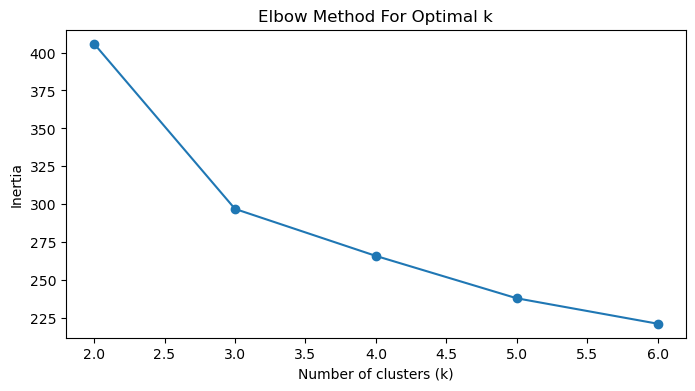

In [31]:
from transformers import CamembertModel, CamembertTokenizer
import numpy as np
from sklearn.cluster import KMeans

tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base')

embeddings = []
for text in risk_corpus:
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings.append(outputs[0].mean(1).squeeze().detach().numpy())

# Stack embeddings for sklearn
embeddings = np.vstack(embeddings)

# Compute clustering and inertia for different values of k
inertias = []
ks = range(2, 7)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    inertias.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(ks, inertias, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


In [55]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

best_k = 3

# Compute k-means clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(embeddings)
labels = kmeans.labels_

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'text': risk_corpus,
    'label': labels
})

/home/medo/anaconda3/envs/unibsv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/medo/anaconda3/envs/unibsv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



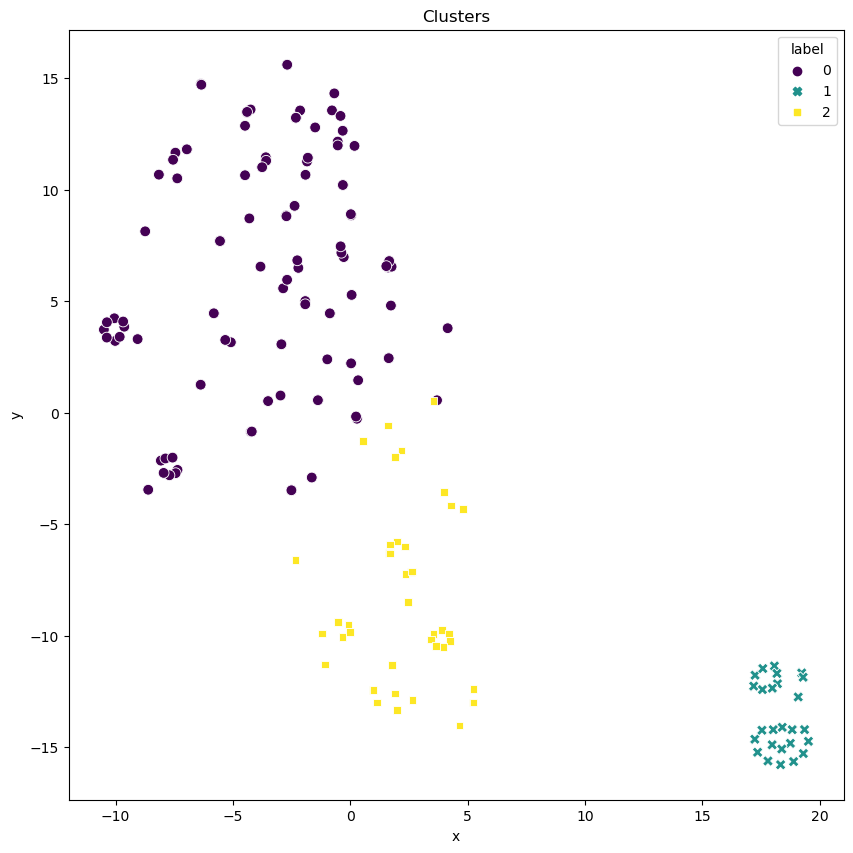

In [56]:
# Plot
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', style='label', s=60)
plt.title('Clusters')
plt.show()

In [57]:
pd.set_option('display.max_colwidth', 100)

df[df["label"]==0]

x          y   
0   -7.368514  10.514114  \
1   -3.753800  11.014474   
2   -5.813230   4.461638   
3    1.637703   2.448222   
4   -1.378169   0.562848   
..        ...        ...   
185 -3.823781   6.556295   
186 -3.501032   0.524233   
188 -8.606688  -3.452543   
189 -7.950520  -2.697060   
190 -9.058433   3.304268   

                                                                                                    text   
0    le 3ème traitement contre le vecteur de la flavescence dorée, rendu obligatoire par arrêté préfe...  \
1    la période de sensibilité à l’oïdium est toujours en cours dans les parcelles les plus tardives ...   
2                             surveillez les pièges, les dépôts des pontes, et leurs stades d’évolution.   
3        le risque est en augmentation avec l’observation des larves. Surveiller les vols et les larves.   
4    Le risque de subir des dégâts sur baie régresse progressivement à partir de la fermeture de grap...   
..                                                                                                   ...   
185  dès à présent, il est primordial de repérer et de marquer les souches atteintes pour les arrache...   
186                                     La sensibilité des grappes devient nulle à la véraison complète.   
188                                                               surveiller l’apparition des symptômes.   
189                                                   surveiller l’apparition des symptômes sur grappes.   
190  repérer les souches exprimant des symptômes qui pourront être gérés par la voie prophylactique a...   

     label  
0        0  
1        0  
2        0  
3        0  
4        0  
..     ...  
185      0  
186      0  
188      0  
189      0  
190      0  

[116 rows x 4 columns]

In [58]:
df[df["label"]==1]

x          y                       text  label
34   18.197142 -12.154084            Il reste faible      1
35   18.017138 -14.214657                 Il est nul      1
40   17.791475 -15.618465                 Il est nul      1
49   19.229116 -11.668805  Il est globalement faible      1
50   18.884075 -15.645529                 Il est nul      1
51   17.977411 -12.352872            Il reste faible      1
52   17.184126 -12.259621            Il reste faible      1
68   18.746632 -14.825113                 Il est nul      1
69   19.290312 -11.862906  Il est globalement faible      1
70   19.299173 -15.285023                 Il est nul      1
71   18.066200 -11.356231            Il reste faible      1
79   19.515486 -14.735909                 Il est nul      1
80   17.970419 -14.891468                 Il est nul      1
81   19.350668 -14.212051                 Il est nul      1
82   17.242100 -11.771432            Il reste faible      1
103  17.556376 -12.416265            Il reste faible      1
138  18.400599 -14.107341                 Il est nul      1
146  17.232376 -14.642289                 Il est nul      1
147  18.824333 -14.214774                 Il est nul      1
148  18.381001 -15.082306                 Il est nul      1
149  18.174070 -11.692560            Il reste faible      1
150  19.080896 -12.748405              Il est faible      1
159  17.572994 -11.472450            Il reste faible      1
179  18.330404 -15.786330                 Il est nul      1
180  17.536413 -14.240038                 Il est nul      1
181  17.350502 -15.227071                 Il est nul      1

In [53]:
df[df["label"]==2]

x          y   
9    2.306120  -5.990569  \
17   1.995584  -5.778125   
25   1.641050  -6.277661   
33   1.684537  -5.902668   
38   3.910388  -9.740932   
39   2.459213  -8.482800   
48  -0.015791  -9.824010   
61   2.599044  -7.129215   
67  -0.336118 -10.069139   
74   2.180816  -1.696841   
76   3.541286  -9.912210   
77  -0.531803  -9.379748   
78   1.140337 -12.996034   
90   1.691484  -6.306834   
91  -2.335105  -6.613291   
101  2.332160  -6.004661   
107  1.775457 -11.306564   
108  4.238344 -10.238125   
110  1.901325  -1.992895   
112  2.642882 -12.892313   
113  4.298739  -4.152677   
114  4.655746 -14.034896   
115  4.653801 -14.033916   
116 -1.088683 -11.291363   
118  4.200974  -9.906715   
121  0.977668 -12.437737   
122  0.977668 -12.437737   
123  5.242638 -12.389787   
126 -1.088683 -11.291363   
128  3.448874 -10.172737   
130  1.901116 -12.585824   
131  0.981359 -12.436990   
132  5.241376 -12.997893   
133  5.238560 -12.995955   
136  3.657443 -10.469459   
137  4.005157  -3.557621   
141  1.606600  -0.565050   
143 -0.336119 -10.069139   
144  0.541015  -1.261119   
145  4.794150  -4.317627   
158 -0.531803  -9.379750   
168  2.350728  -7.218473   
169 -1.204981  -9.895298   
172  1.775717 -11.306743   
173  3.971169 -10.504473   
175 -0.082560  -9.497212   
176  1.988598 -13.323280   
178  5.241376 -12.997893   
187  3.549196   0.520994   
191  2.627807  -7.117839   
192 -1.204981  -9.895298   

                                                                                                    text   
9                                                               A ce jour, le risque est en augmentation  \
17                                                              A ce jour, le risque est en augmentation   
25                                                              A ce jour, le risque est en augmentation   
33                                                              A ce jour, le risque est en augmentation   
38                                                                         le risque est nul à ce stade.   
39                                                                           le risque reste très faible   
48                                                                         A ce jour, le risque est nul.   
61                                                                       A ce jour, le risque est faible   
67                                                                         A ce jour, le risque est nul.   
74   le risque augmente notamment dans l’Hérault sur les parcelles à historique. Observer vos parcell...   
76                                                                         le risque est nul à ce stade.   
77                                                                         A ce jour, le risque est nul.   
78                                                                               le risque reste faible.   
90                                                              A ce jour, le risque est en augmentation   
91                                                             il est lié à l’historique de la parcelle.   
101                                                             A ce jour, le risque est en augmentation   
107                                                                       le risque est en augmentation.   
108                                                                        le risque est nul à ce stade.   
110                            le risque peut être important sur les parcelles et secteurs à historique.   
112                                                                                 e risque est faible.   
113                                                             le risque reste très faible.  Escargots   
114                                                                                           Risque nul   
115                                                                    

In [54]:
df[df["label"]==3]

Empty DataFrame
Columns: [x, y, text, label]
Index: []

In [48]:
import plotly.express as px

# Create a DataFrame
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'text': risk_corpus,
    'label': labels
})

# Create a scatter plot
fig = px.scatter(df, x='x', y='y', color='label', hover_data=['text'])

# Show the plot
fig.show()

In [60]:
from transformers import pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px

# sentiment analysis pipeline
nlp = pipeline('sentiment-analysis')

# Perform sentiment analysis on your texts
sentiments = [nlp(text)[0] for text in risk_corpus]
sentiment_scores = [s['score'] if s['label'] == 'POSITIVE' else -s['score'] for s in sentiments]

# Add sentiment scores to your DataFrame
df['sentiment'] = sentiment_scores

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df[['x', 'y', 'sentiment']]), columns=['PC1', 'PC2'])

# Perform clustering
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(df_pca)
df_pca['label'] = kmeans.labels_

# Add texts to the DataFrame for hover data in the plot
df_pca['text'] = risk_corpus

# Create a scatter plot
fig = px.scatter(df_pca, x='PC1', y='PC2', color='label', hover_data=['text'])
fig.show()

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
